### Import dependencies

In [1]:
## Get dependencies ##

import numpy as np
import string
import math
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn
sys.path.append('..')
from GIR import *
import scipy as sp
import pickle
import time
import scipy as sp
from scipy import ndimage
from scipy import signal
import os
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import requests
import ftplib
import PyPDF2
import io
import cmocean
import multiprocessing
from pdfo import pdfo,Bounds

import xarray as xr

xr.set_options(display_style='html')

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()
    
## Matplotlib rcparams setup:

matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400

matplotlib.rcParams['image.cmap']='cmo.ice'

matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
matplotlib.rcParams['axes.labelweight']=300

matplotlib.rcParams['legend.frameon']=False

matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'

matplotlib.rcParams['errorbar.capsize']=5

matplotlib.rcParams['hist.bins']='auto'

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

## Tuning to CMIP6 forcing response 
Using the methodology of Cummins et al. (2020), we fit CMIP6 models to the EBM of Geoffrey based on a recursive Kalman filter MLE algorithm, using data from both the 1pctCO2 and abrupt-4xCO2 experiments to best constrain the parameters under both transient and equilibrium conditions.

#### Import the CMIP6 datasets

In [2]:
abrupt_4x_data = pd.read_csv('../tools/cmip6_data/abrupt-4xCO2.csv',index_col=0)
onepct_data = pd.read_csv('../tools/cmip6_data/onepct.csv',index_col=0)
picontrol_data = pd.read_csv('../tools/cmip6_data/piControl.csv',index_col=0)

for i,x in enumerate(['source','member','variable']):
    abrupt_4x_data.loc[x] = [x.split('_')[i+1] for x in abrupt_4x_data.columns]
    picontrol_data.loc[x] = [x.split('_')[i+1] for x in picontrol_data.columns]
    onepct_data.loc[x] = [x.split('_')[i+1] for x in onepct_data.columns]

abrupt_4x_data=abrupt_4x_data.T.set_index(['source','member','variable']).T
picontrol_data=picontrol_data.T.set_index(['source','member','variable']).T
onepct_data=onepct_data.T.set_index(['source','member','variable']).T

In [3]:
cmip6_exp_info = pd.read_csv('../tools/cmip6_data/cmip6_branch_info.csv',index_col=0)

## a few bits we'll need:

calendar_info = dict(zip(["<class 'cftime._cftime.DatetimeNoLeap'>","<class 'numpy.datetime64'>","<class 'cftime._cftime.DatetimeJulian'>","<class 'cftime._cftime.DatetimeProlepticGregorian'>","<class 'cftime._cftime.DatetimeGregorian'>","<class 'cftime._cftime.Datetime360Day'>"],[365,365.2422,365.25,365.2425,365.2425,360]))

cmip6_exp_info.loc['calendar_length'] = [calendar_info[x] for x in cmip6_exp_info.loc['calendar']]

for i,x in enumerate(['source','member','experiment']):
    cmip6_exp_info.loc[x] = [x.split('_')[i+1] for x in cmip6_exp_info.columns]
    
cmip6_exp_info=cmip6_exp_info.T.set_index(['source','member','experiment']).T

cmip6_exp_info.loc['parent_branch_time'] = cmip6_exp_info.loc['parent_branch_time'].astype(float)

cmip6_exp_info.loc['parent_branch_time','BCC-CSM2-MR'] = 281*cmip6_exp_info.loc['calendar_length','BCC-CSM2-MR'].values[0]
cmip6_exp_info.loc['parent_branch_time','BCC-ESM1'] = (2110-1850)*cmip6_exp_info.loc['calendar_length','BCC-ESM1'].values[0]
cmip6_exp_info.loc['parent_branch_time','CAMS-CSM1-0'] = 0.0
cmip6_exp_info.loc['parent_branch_time','MRI-ESM2-0'] = (cmip6_exp_info.loc['parent_branch_time','MRI-ESM2-0'].apply(pd.to_numeric)*cmip6_exp_info.loc['calendar_length','MRI-ESM2-0'].apply(pd.to_numeric)).values
cmip6_exp_info.loc['parent_branch_time',('TaiESM1','r1i1p1f1','abrupt-4xCO2')] = 500*365

cmip6_exp_info.loc['parent_variant','CNRM-ESM2-1'] = 'r1i1p1f2'
cmip6_exp_info.loc['parent_variant','CIESM'] = 'r1i1p1f1'

cmip6_exp_info.loc['parent_branch_time_years'] = [round(x) for x in cmip6_exp_info.loc['parent_branch_time'].apply(pd.to_numeric) / cmip6_exp_info.loc['calendar_length']]

# CanESM5 meta data actually measured relative to the time axes of the data, rather than to zero (as appears to be the case for other data)
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p1f1')] = 1850-5200 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p1f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p1f1')] = 1850-5200 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p1f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p1f1')] = 1850-5200 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p1f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r3i1p2f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r2i1p2f1')].values
cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5','r1i1p2f1')].values

cmip6_exp_info.loc['parent_branch_time_years',('CanESM5-CanOE','r1i1p2f1')] = 1850-5550 + cmip6_exp_info.loc['parent_branch_time_years',('CanESM5-CanOE','r1i1p2f1')].values

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


### Simple baseline temperature estimation and drift correction

- We estimate the baseline temperature by:
    - If piControl data exists, from a linear regression of a 20 year period around the branch point. The linear model temperature at the branch point is the baseline temperature
    - If no piControl exists, we follow Sanderson (2020); and estimate the baseline temperature with a linear regression of the first 20 years of the 1pctCO2 run
    - If neither exists, we remove the model from our analysis
- We estimate the drift by:
    - using a linear regression of the piControl of the same length as the experiment data (if exists), starting from the branch point
    - If piControl length is insufficient, we use a linear regression of 150 years (or as long as the experiment data), ending in the final year of available piControl data
    
- Other points:
    - If the abrupt-4xCO2 data is less than 50 years in length, we remove the model
    - Before estimating parameters, we take the average of different ensemble members
    - If rsdt does not exist for abrupt-4xCO2, we use data from piControl or onepct if availablepicontrol_data

In [112]:
## let's get the baseline temps / drift slopes from the piControl:

def get_intercept_slope_tas(model,member,length):

    picontrol_member = cmip6_exp_info.loc['parent_variant',(model,member,'abrupt-4xCO2')]
    picontrol_tas = picontrol_data[model][picontrol_member]['tas'].dropna().astype(float)
    branch_point = cmip6_exp_info.loc['parent_branch_time_years',(model,member,'abrupt-4xCO2')]
    
    if (branch_point + length) < picontrol_tas.size:
        start = branch_point
        end = branch_point+length
        startidx = 0
        endidx=length
    else:
        if picontrol_tas.size < length:
            length = picontrol_tas.size
        start = picontrol_tas.size - length
        end = None
        startidx = start - branch_point
        endidx = start - branch_point + length
    
    _lr = sp.stats.linregress(np.arange(startidx,endidx),picontrol_tas.iloc[start:end])
    
    return _lr.intercept, _lr.slope

In [113]:
tas_baseline_slope = pd.DataFrame(index=['intercept','slope'],columns=abrupt_4x_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in abrupt_4x_data.xs('tas',axis=1,level=-1).columns:
    
    abrupt_4x_length = abrupt_4x_data[mod_mem[0]][mod_mem[1]].dropna().shape[0]
    
    if abrupt_4x_length<50:
        continue
    
    tas_baseline_slope.loc[:,mod_mem] = get_intercept_slope_tas(mod_mem[0],mod_mem[1],abrupt_4x_length)

In [114]:
## let's get the baseline temps / drift slopes from the piControl:

def get_intercept_slope_N(model,member,length):

    picontrol_member = cmip6_exp_info.loc['parent_variant',(model,member,'abrupt-4xCO2')]
    picontrol_all = picontrol_data[model][picontrol_member].astype(float)
    if not ('rsut' in picontrol_all.columns and 'rlut' in picontrol_all.columns):
        return np.nan
        
    if len(set(picontrol_all.rsut.dropna().index).intersection(set(picontrol_all.rlut.dropna().index)))<100:
        return picontrol_all.rsut.mean() + picontrol_all.rlut.mean(),0
        
    picontrol_N = (picontrol_all.rsut + picontrol_all.rlut).dropna()
    
    branch_point = cmip6_exp_info.loc['parent_branch_time_years',(model,member,'abrupt-4xCO2')]
    
    if (branch_point + length) < picontrol_N.size:
        start = branch_point
        end = branch_point+length
        startidx = 0
        endidx=length
    else:
        if picontrol_N.size < length:
            length = picontrol_N.size
        start = picontrol_N.size - length
        end = None
        startidx = start - branch_point
        endidx = start - branch_point + length
    
    _lr = sp.stats.linregress(np.arange(startidx,endidx),picontrol_N.iloc[start:end])
    
    return _lr.intercept, _lr.slope

In [115]:
N_baseline_slope = pd.DataFrame(index=['intercept','slope'],columns=abrupt_4x_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in abrupt_4x_data.xs('tas',axis=1,level=-1).columns:
    
    abrupt_4x_length = abrupt_4x_data[mod_mem[0]][mod_mem[1]].dropna().shape[0]
    
    if abrupt_4x_length<50:
        continue
    
    N_baseline_slope.loc[:,mod_mem] = get_intercept_slope_N(mod_mem[0],mod_mem[1],abrupt_4x_length)

In [116]:
## now we compute the drift corrected anomaly datasets:
abrupt_4x_data_corr = pd.concat([pd.DataFrame(index = list(np.arange(2000)), columns = abrupt_4x_data.xs('tas',axis=1,level=-1).columns)]*2,axis=1,keys=['tas','N']).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1)

for mod_mem in abrupt_4x_data.xs('tas',axis=1,level=-1).columns:
    
    if mod_mem in N_baseline_slope.dropna(axis=1).columns and mod_mem in tas_baseline_slope.dropna(axis=1).columns:
        
        if 'rsut' in abrupt_4x_data.loc[:,mod_mem].columns and 'rlut' in abrupt_4x_data.loc[:,mod_mem].columns and 'tas' in abrupt_4x_data.loc[:,mod_mem].columns:
        
            mod_tas_data = abrupt_4x_data.loc[:,mod_mem].tas.astype(float).dropna()
            abrupt_4x_data_corr.loc[:mod_tas_data.size-1,(*mod_mem,'tas')] = mod_tas_data.values - tas_baseline_slope.loc['intercept',mod_mem] - np.arange(mod_tas_data.size) * tas_baseline_slope.loc['slope',mod_mem]

            mod_N_data = (abrupt_4x_data.loc[:,mod_mem].rsut.astype(float)+abrupt_4x_data.loc[:,mod_mem].rlut.astype(float)).dropna()
            abrupt_4x_data_corr.loc[:mod_tas_data.size-1,(*mod_mem,'N')] = mod_N_data.values - N_baseline_slope.loc['intercept',mod_mem] - np.arange(mod_N_data.size) * N_baseline_slope.loc['slope',mod_mem]

/home/leachl/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [117]:
# these members have something off (GISS just looks wrong, MRI appear to have been started at some point DURING the year...)
abrupt_4x_data_corr = abrupt_4x_data_corr.drop([('GISS-E2-1-G','r1i1p1f3','tas'),('GISS-E2-1-G','r1i1p1f3','N'),\
                         ('MRI-ESM2-0','r4i1p1f1','tas'),('MRI-ESM2-0','r4i1p1f1','N'),\
                         ('MRI-ESM2-0','r7i1p1f1','tas'),('MRI-ESM2-0','r7i1p1f1','N')],axis=1).dropna(axis=1,how='all').apply(pd.to_numeric)

## these next members appear to have a year of picontrol at the start
abrupt_4x_data_corr.loc[:1998,('MRI-ESM2-0',['r10i1p1f1','r13i1p1f1'])] = abrupt_4x_data_corr.loc[1:,('MRI-ESM2-0',['r10i1p1f1','r13i1p1f1'])].values

/home/leachl/miniconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [10]:
fit_data = abrupt_4x_data_corr.fillna(np.inf).groupby(level=(0,2),axis=1).mean().replace(np.inf, np.nan)

#### Create the required definitions

In [13]:
def BuildMat(params):
#     param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_2x']
    A = np.array([[-1*params[0],0,0,0],\
                     [1/params[1],-1*(params[4]+params[5])/params[1],params[5]/params[1],0],\
                     [0,params[5]/params[2],-1*(params[5]+params[7]*params[6])/params[2],params[7]*params[6]/params[2]],\
                     [0,0,params[6]/params[3],-1*params[6]/params[3]]])
    k = A.shape[0]
    b = np.array([params[0],0,0,0]).T
    Q = np.zeros((4,4))
    Q[0,0] = params[8]**2
    Q[1,1] = (params[9]/params[1])**2
    A_d = sp.linalg.expm(A)
    b_d = sp.linalg.solve(A, (A_d - np.identity(k)) @ b)
    ## use Van Loan (1978) to compute the matrix exponential
    H = np.zeros((k*2,k*2))
    H[:k,:k] = -A
    H[:k,k:] = Q
    H[k:,k:] = A.T
    G = sp.linalg.expm(H)
    Q_d = G[k:,k:].T @ G[:k,k:]
    C_d = np.array([[0,1,0,0],\
                   [1,-1*params[4],(1-params[7])*params[6],-1*(1-params[7])*params[6]]])
    
    return A,b,Q,A_d,b_d,Q_d,C_d

def Kalman(a0, P0, dt, ct, Tt, Zt, HHt, GGt, yt):
    
    # computes a Kalman filter recursively over all the timesteps of the input data, yt
    # returns the Negative log likelihood for fitting
    
    n = yt.shape[1] # measurements
    k = a0.shape[0] # state dimension size
    d = yt.shape[0] # measurement dimensions
    vt = np.zeros((d,n))
    Ft = np.zeros((d,d,n))
    Kt = np.zeros((k,d,n))
    at = np.zeros((k,n+1))
    Pt = np.zeros((k,k,n+1))
    nll = 0

    at[...,0] = a0
    Pt[...,0] = P0

    for i in np.arange(n):
        vt[...,i] = yt[...,i] - ct - Zt @ at[...,i]
        Ft[...,i] = Zt @ Pt[...,i] @ Zt.T + GGt
        Kt[...,i] = Pt[...,i] @ Zt.T @ np.linalg.inv(Ft[...,i])
        att = at[...,i] + Kt[...,i] @ vt[...,i]
        Ptt = Pt[...,i] - Pt[...,i] @ Zt.T @ Kt[...,i].T

        at[...,i+1] = dt[...,i] + Tt@att
        Pt[...,i+1] = Tt @ Ptt @ Tt.T + HHt
        
        nll += np.log(2*np.pi) + (1/2) * (  np.log(np.linalg.det(Ft[...,i])) + vt[...,i].T @ np.linalg.inv(Ft[...,i]) @ vt[...,i] )
        
    return nll

In [12]:
def nll_abrupt4x(par,yt,transform=True):
    
    if transform:
        par = np.exp(par)
    
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(par)
    k = A.shape[0]
    u = np.full(yt.shape[-1],par[-1]).reshape(1,-1)
    
    gamma0 = (sp.linalg.solve(np.identity(k**2)-np.kron(A_d,A_d),Q_d.flatten())).reshape(4,4)
    x0 = np.array([par[-1],0,0,0])
    a0 = A_d@x0 + b_d*u[...,0]
    
    P0 = gamma0.copy()
    dt = (b_d.reshape(-1,1)@u)
    ct = np.zeros(2)
    Tt = A_d.copy()
    Zt = C_d.copy()
    HHt = Q_d.copy()
    GGt = np.identity(2)*1e-15
    
    return Kalman(a0, P0, dt, ct, Tt, Zt, HHt, GGt, yt)

In [13]:
def visual_check_abrupt4x(source,fit_params):

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    
    CMIP6_data = fit_data[source].dropna()
    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(fit_params)
    
#     w_d = sp.stats.multivariate_normal(mean = None , cov = Q_d, allow_singular=True)
    
    x = np.zeros((CMIP6_data.shape[0]+1,4))
    y = np.zeros((CMIP6_data.shape[0]+1,2))
    
    x[:,0] = fit_params[-1]
    y[0,:] = C_d @ x[0]
    
    for t in np.arange(x.shape[0]-1):
        x[t+1] = A_d@x[t]+b_d*fit_params[-1]
        y[t+1] = C_d@x[t+1]
    
    ax[0].plot(np.arange(CMIP6_data.shape[0]),y[1:,0],ls='--')
    ax[0].plot(np.arange(CMIP6_data.shape[0]),CMIP6_data['tas'].values)
    ax[1].plot(np.arange(CMIP6_data.shape[0]),y[1:,1],ls='--')
    ax[1].plot(np.arange(CMIP6_data.shape[0]),-1*CMIP6_data['N'].values,label=source)
    ax[2].plot(y[1:,0],y[1:,1],ls='--')
    ax[2].plot(CMIP6_data['tas'].values,-1*CMIP6_data['N'].values,'o',ms=1,zorder=0)
    
    ax[0].set_title('tas')
    ax[1].set_title('TOA EB')
    ax[2].set_title('tas / TOA EB')
    
    fig.suptitle(source+' verification',fontweight='bold')
    
    return y

In [14]:
def fit_source(source,plot_output=False):
    
#     print('getting data for '+source)
    
    abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
    # param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']
    
    par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

    print('fitting '+source)
    
    fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),options={'maxfev':20000})
    
    if fit_params.success==1:
        print(source+' fit converged')
        
        if plot_output:
            visual_check_abrupt4x(source,np.exp(fit_params.x))
            plt.show()

        return pd.Series(np.exp(fit_params.x),index=['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_4x']).rename(source)
    
    else:
        print('trying BOBYQA')
        fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})
        
        if fit_params.success==1:
            print(source+' fit converged with BOBYQA')
        
            if plot_output:
                visual_check_abrupt4x(source,np.exp(fit_params.x))
                plt.show()

            return pd.Series(np.exp(fit_params.x),index=['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_4x']).rename(source)
    
        else:
        
            print(source+' fit failed')
            return None

### Fitting the CMIP6 ensemble

fitting ACCESS-CM2
ACCESS-CM2 fit converged


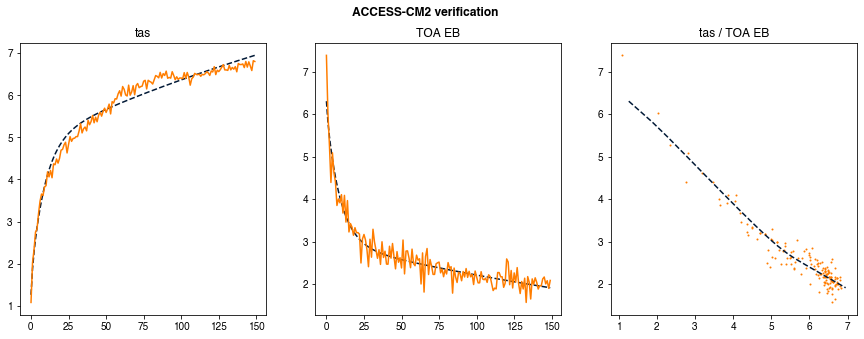

fitting ACCESS-ESM1-5
ACCESS-ESM1-5 fit converged


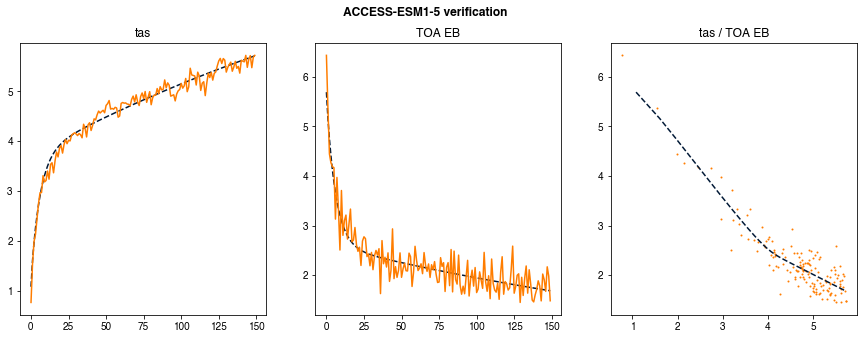

fitting AWI-CM-1-1-MR
AWI-CM-1-1-MR fit converged


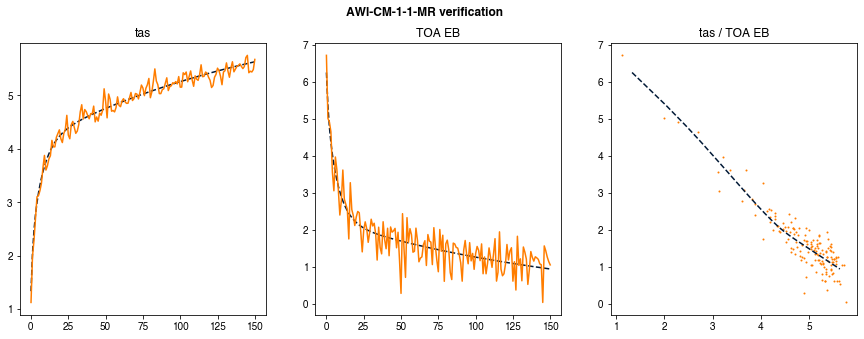

fitting BCC-CSM2-MR
BCC-CSM2-MR fit converged


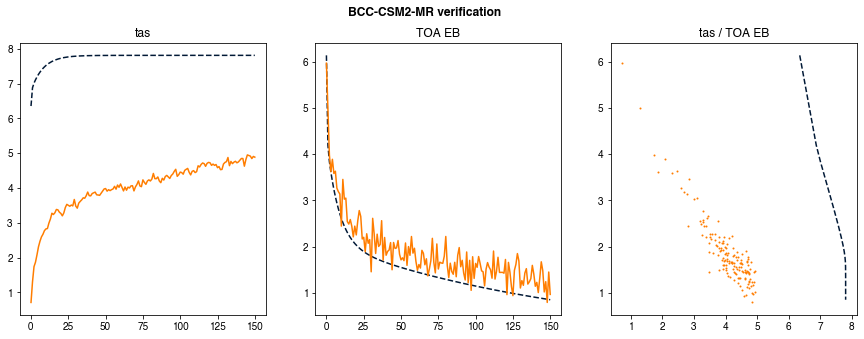

fitting BCC-ESM1
BCC-ESM1 fit converged


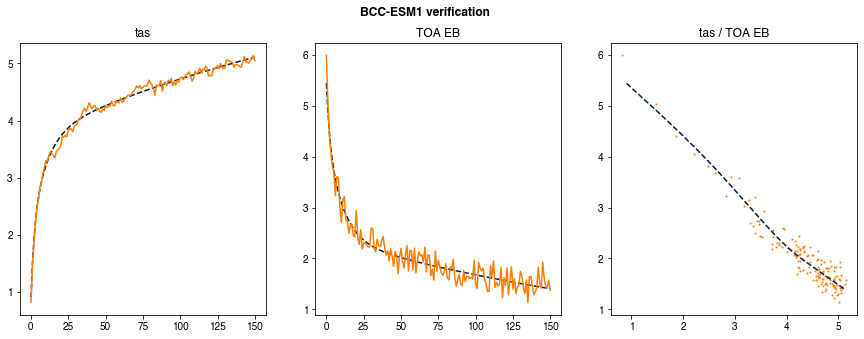

fitting CAMS-CSM1-0
CAMS-CSM1-0 fit converged


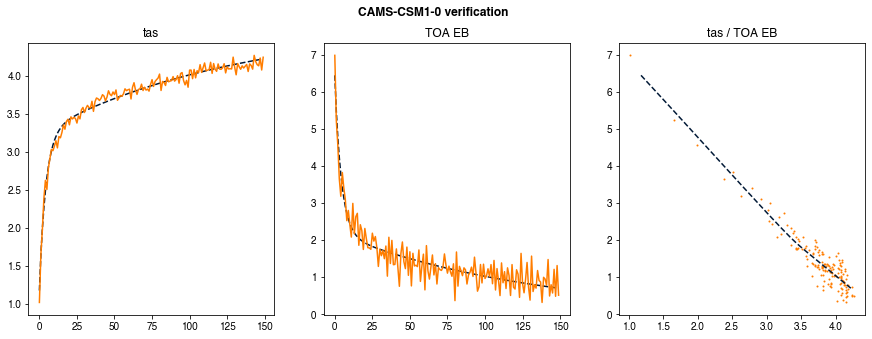

fitting CESM2
CESM2 fit converged


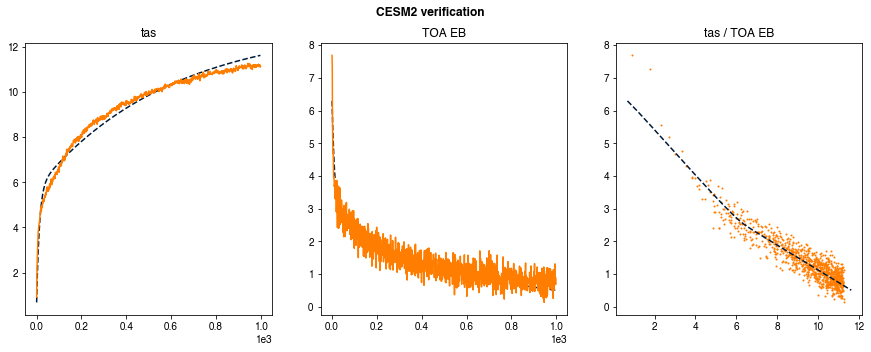

fitting CESM2-FV2
CESM2-FV2 fit converged


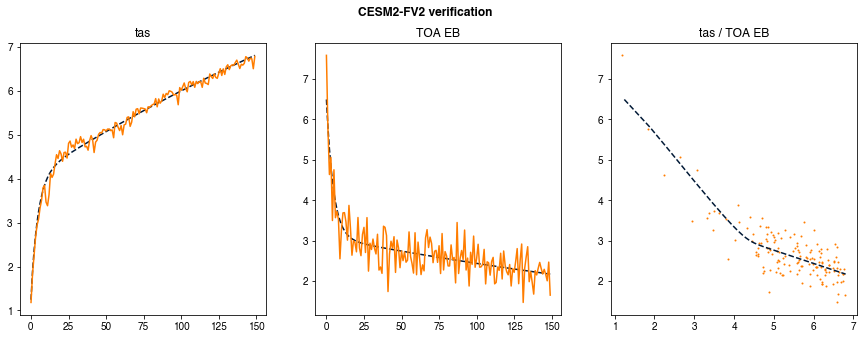

fitting CESM2-WACCM
CESM2-WACCM fit converged


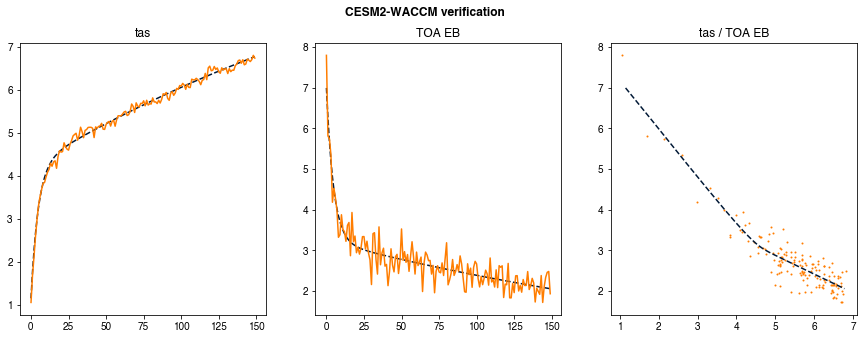

fitting CESM2-WACCM-FV2
CESM2-WACCM-FV2 fit converged


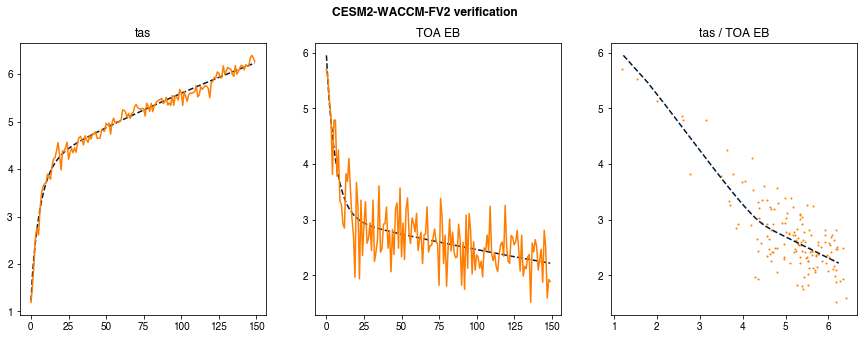

fitting CIESM
CIESM fit converged


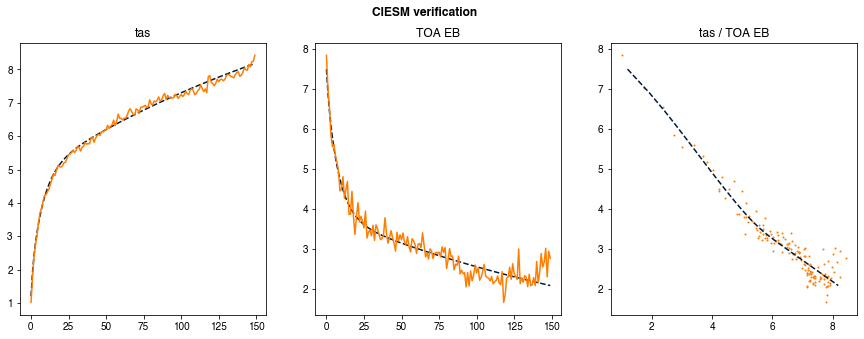

fitting CNRM-CM6-1
CNRM-CM6-1 fit converged


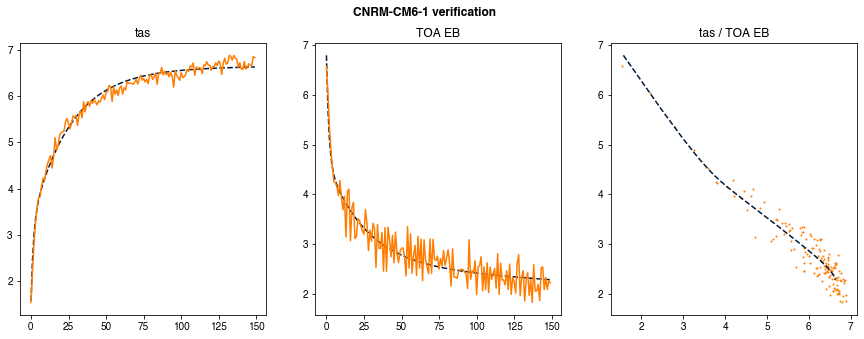

fitting CNRM-CM6-1-HR
CNRM-CM6-1-HR fit converged


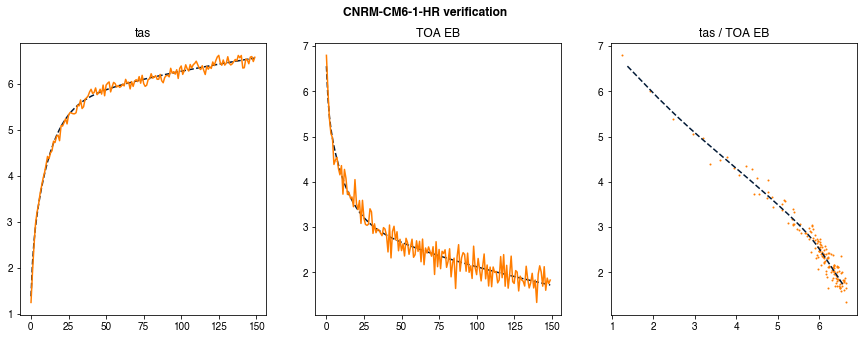

fitting CNRM-ESM2-1
CNRM-ESM2-1 fit converged


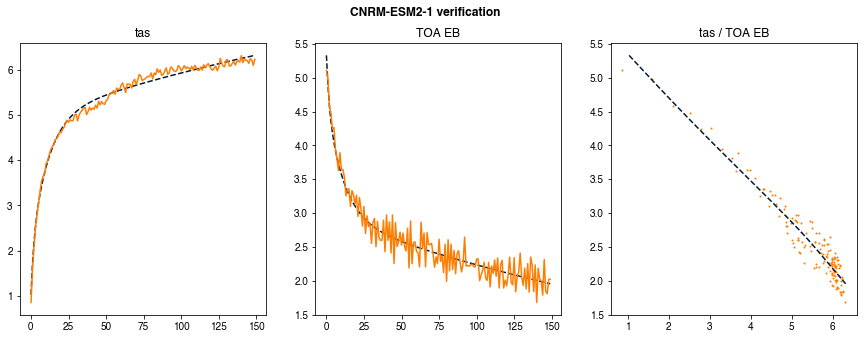

fitting CanESM5
CanESM5 fit converged


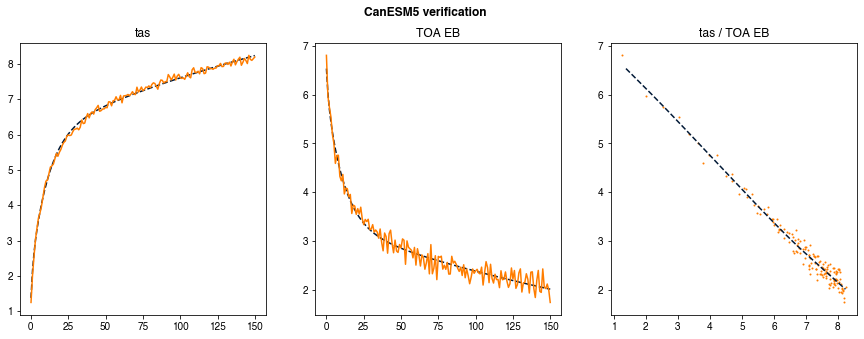

fitting E3SM-1-0
E3SM-1-0 fit converged


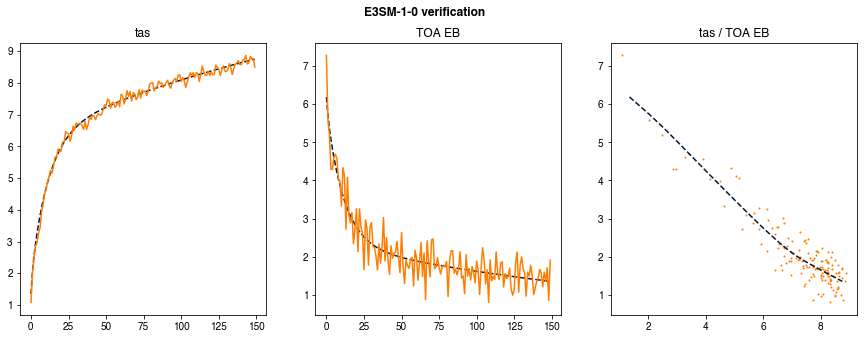

fitting EC-Earth3-Veg
EC-Earth3-Veg fit converged


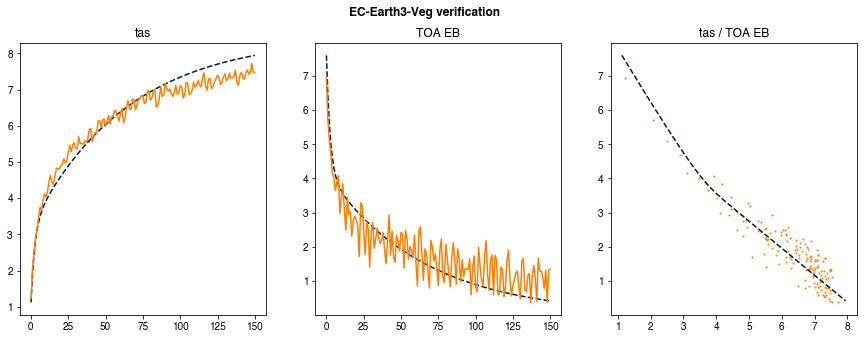

fitting GFDL-CM4
GFDL-CM4 fit converged


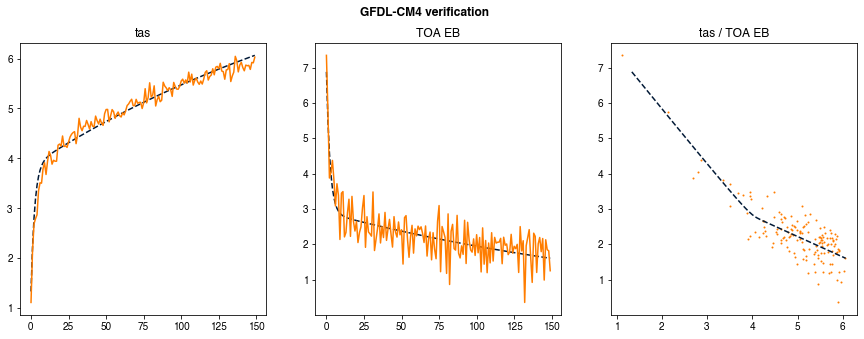

fitting GFDL-ESM4
GFDL-ESM4 fit converged


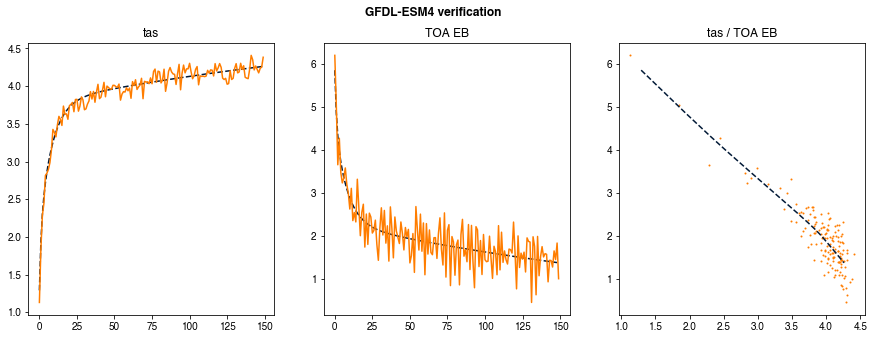

fitting GISS-E2-1-G
GISS-E2-1-G fit converged


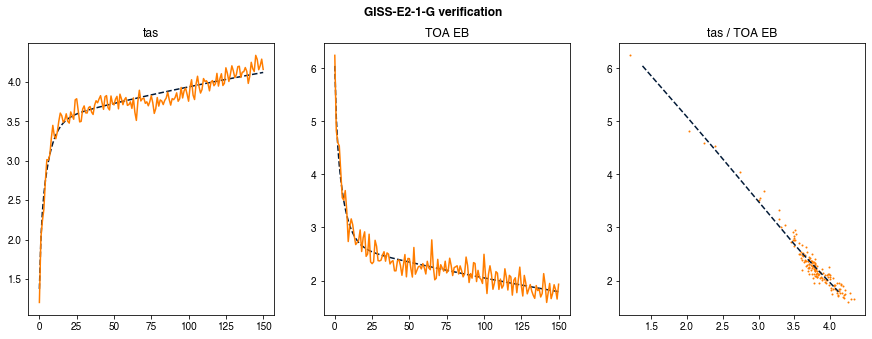

fitting GISS-E2-1-H
trying BOBYQA
GISS-E2-1-H fit converged with BOBYQA


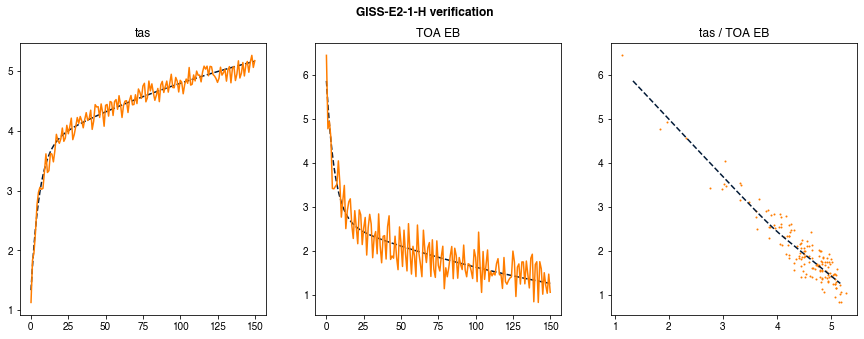

fitting GISS-E2-2-G
GISS-E2-2-G fit converged


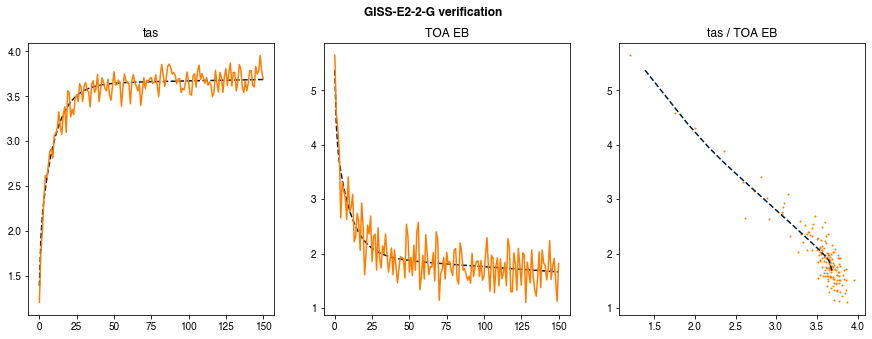

fitting HadGEM3-GC31-LL
HadGEM3-GC31-LL fit converged


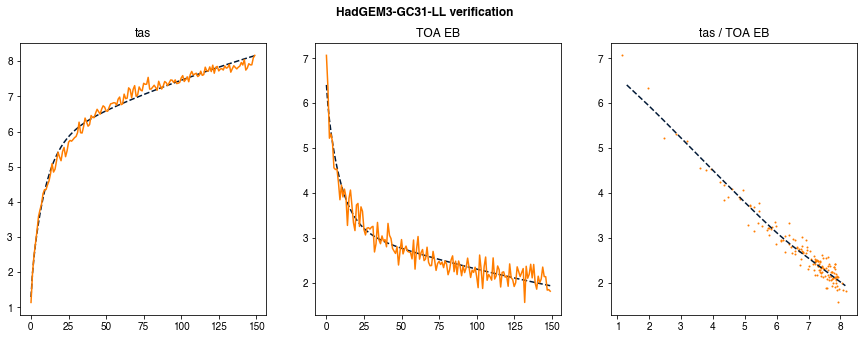

fitting HadGEM3-GC31-MM
HadGEM3-GC31-MM fit converged


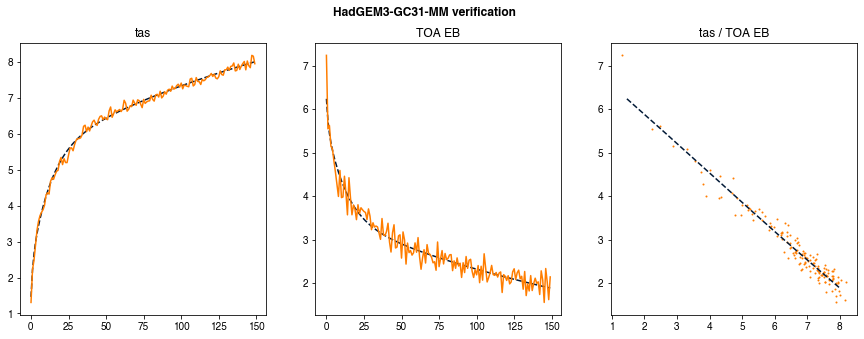

fitting INM-CM4-8
INM-CM4-8 fit converged


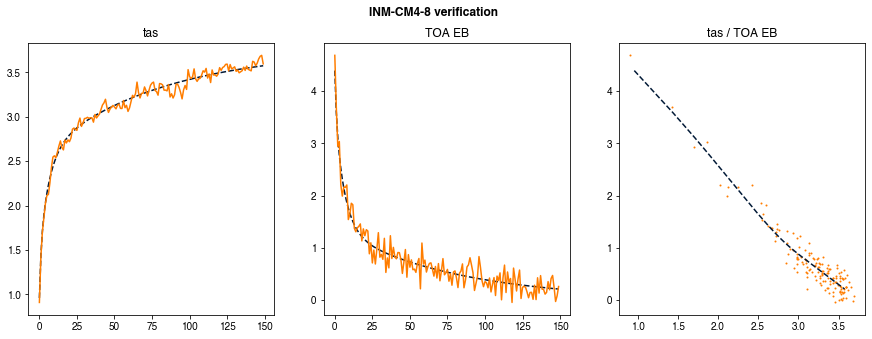

fitting INM-CM5-0
INM-CM5-0 fit converged


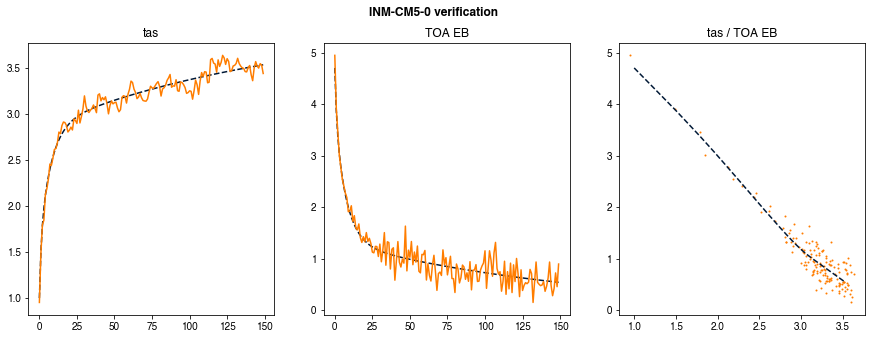

fitting IPSL-CM6A-LR
IPSL-CM6A-LR fit converged


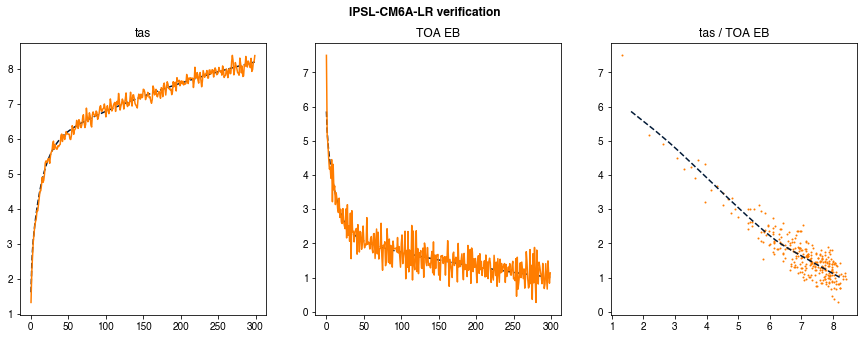

fitting KACE-1-0-G
KACE-1-0-G fit converged


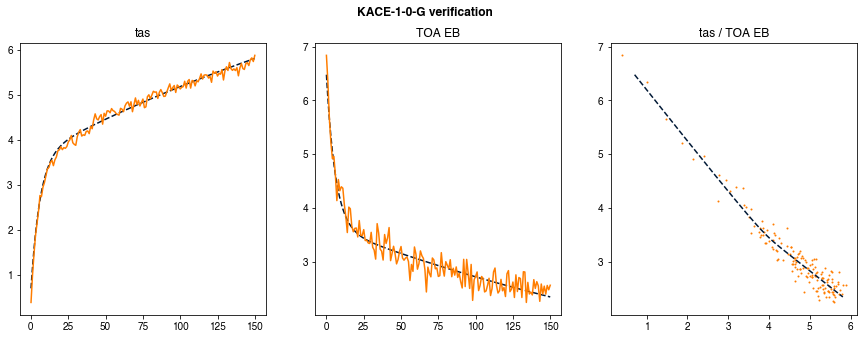

fitting MIROC-ES2L
trying BOBYQA
MIROC-ES2L fit failed
fitting MIROC6
MIROC6 fit converged


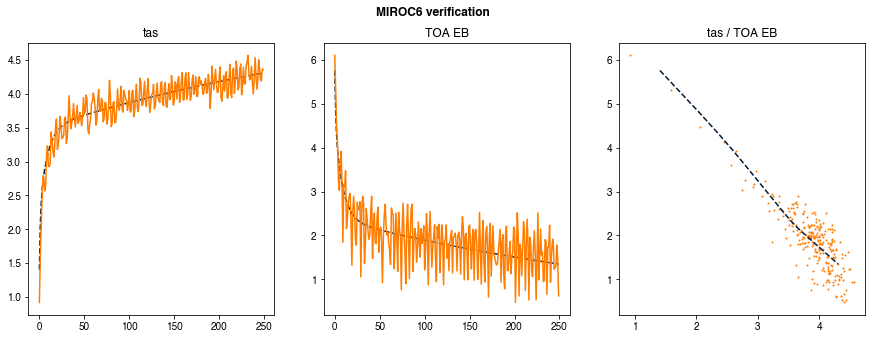

fitting MPI-ESM1-2-HR
MPI-ESM1-2-HR fit converged


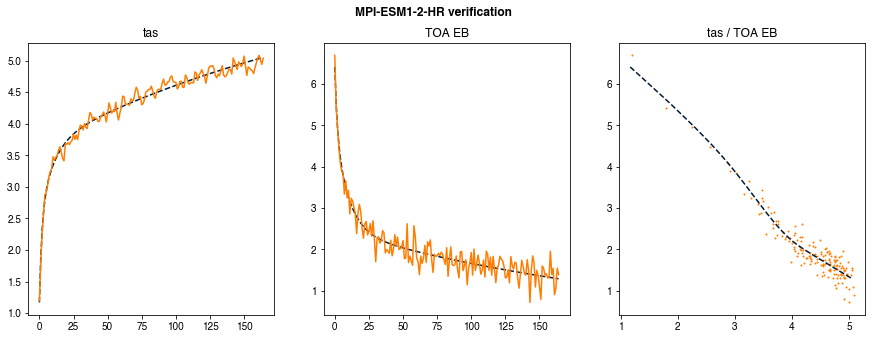

fitting MPI-ESM1-2-LR
MPI-ESM1-2-LR fit converged


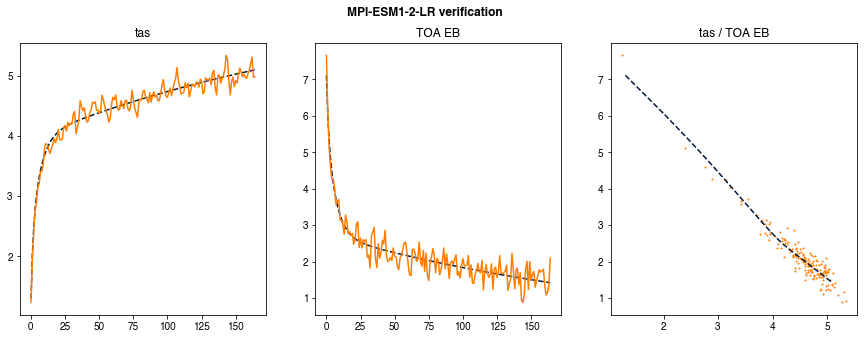

fitting MRI-ESM2-0
MRI-ESM2-0 fit converged


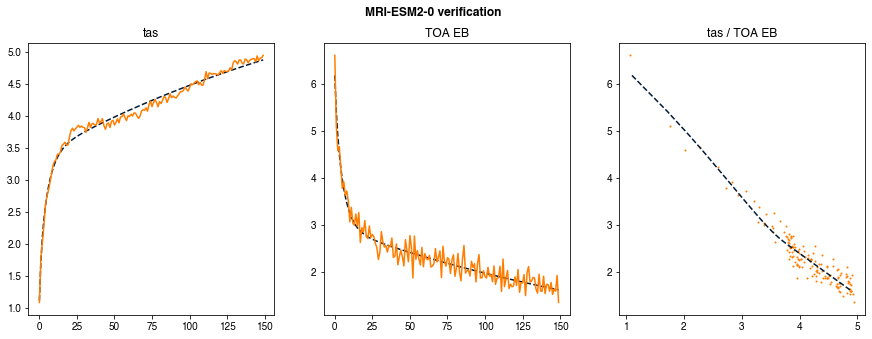

fitting NESM3
NESM3 fit converged


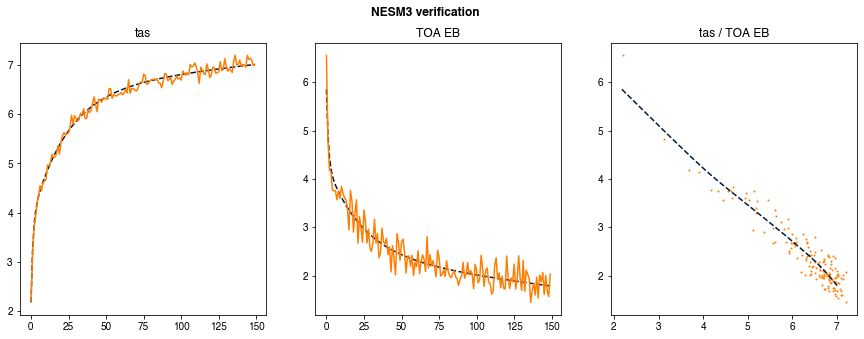

fitting NorCPM1
NorCPM1 fit converged


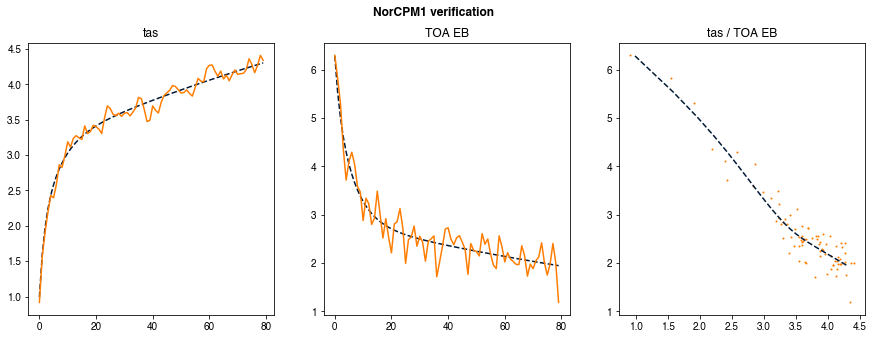

fitting NorESM2-LM
trying BOBYQA
NorESM2-LM fit failed
fitting NorESM2-MM
trying BOBYQA
NorESM2-MM fit failed
fitting SAM0-UNICON
SAM0-UNICON fit converged


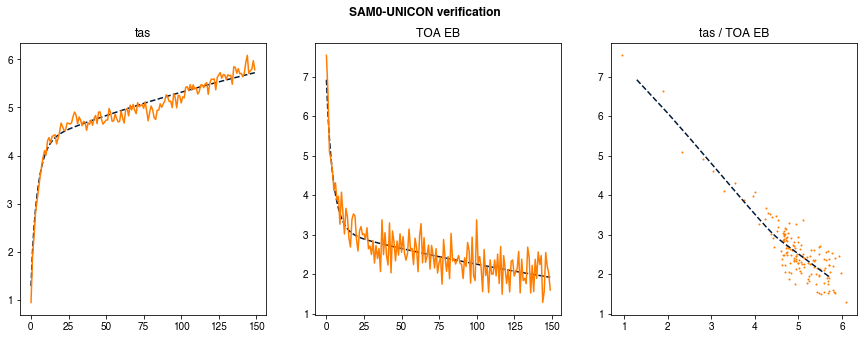

fitting TaiESM1
TaiESM1 fit converged


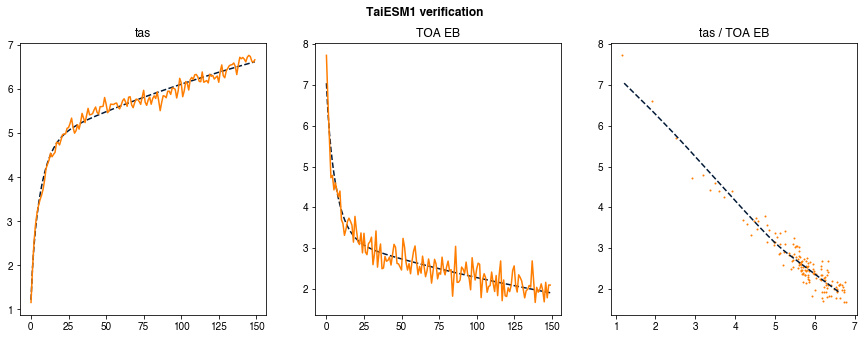

fitting UKESM1-0-LL
UKESM1-0-LL fit converged


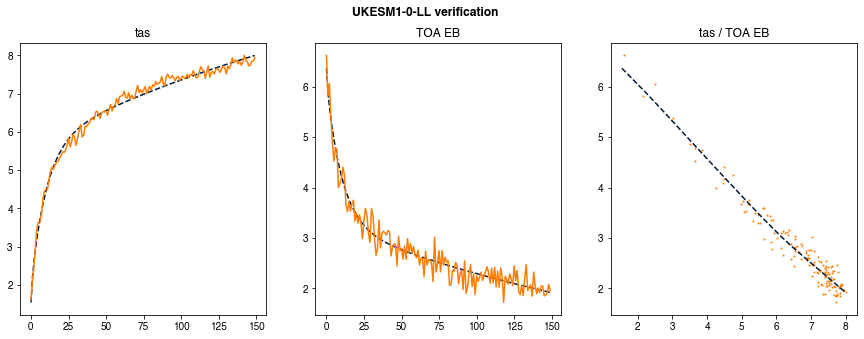

In [248]:
result_abrupt4x = []
for source in fit_data.columns.levels[0]:
    result_abrupt4x += [fit_source(source,True)]

In [ ]:
res_df = pd.concat(result_abrupt4x,axis=1)
res_df

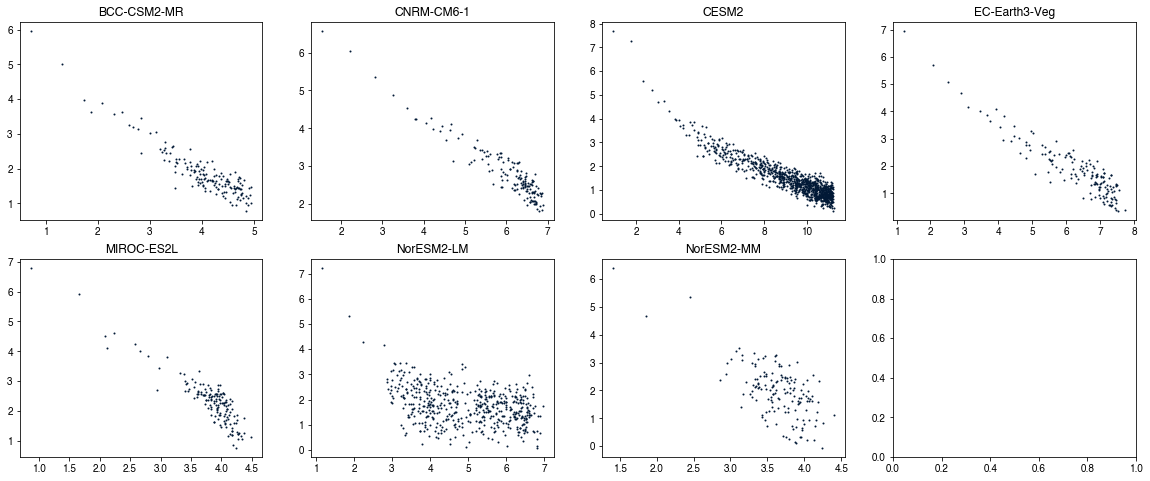

In [260]:
## Failed

failed_sources = ['BCC-CSM2-MR','CNRM-CM6-1','CESM2','EC-Earth3-Veg','MIROC-ES2L','NorESM2-LM','NorESM2-MM']

fig,ax = plt.subplots(2,4,figsize=(20,8))

for i,x in enumerate(failed_sources):
#     fit_data[x]['tas'].plot(ax=ax.flatten()[i])
#     (-1*fit_data[x]['N']).plot(ax=ax.flatten()[i])
    ax.flatten()[i].plot(fit_data[x]['tas'],(-1*fit_data[x]['N']),'o',ms=1)
    ax.flatten()[i].set_title(x)

fitting BCC-CSM2-MR
BCC-CSM2-MR fit converged


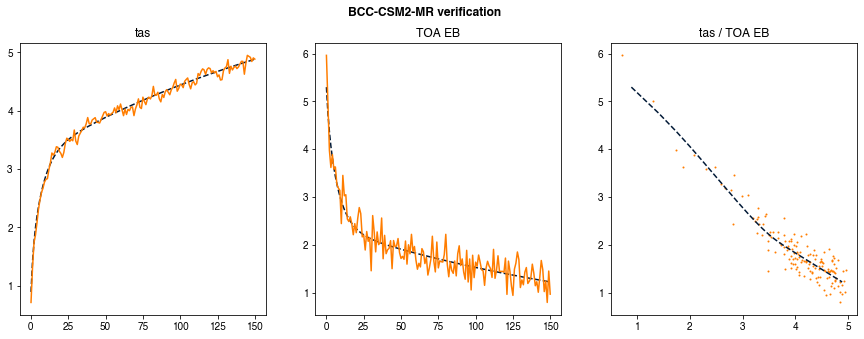

In [264]:
source = failed_sources[0]
plot_output=True

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 6.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [268]:
res_df.loc[:,failed_sources[0]] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[1]
b, a = sp.signal.butter(2 , 0.3)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values),'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

fitting CNRM-CM6-1
CNRM-CM6-1 fit converged


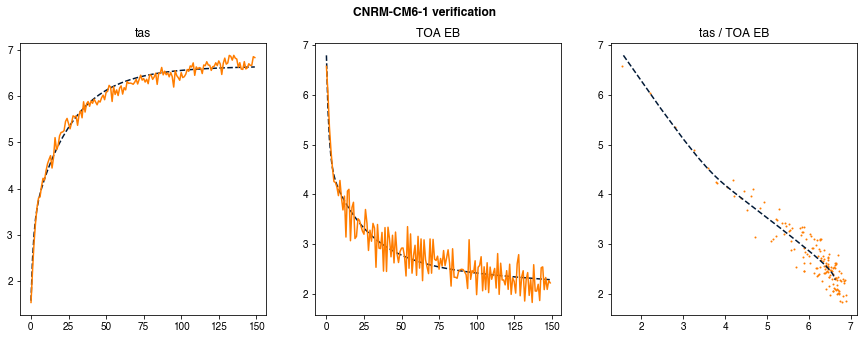

In [602]:
source = failed_sources[1]
plot_output=True

b, a = sp.signal.butter(2 , 0.2)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)])

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 7.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='lincoa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [603]:
res_df.loc[:,source] = np.exp(fit_params.x)

fitting CESM2
CESM2 fit converged


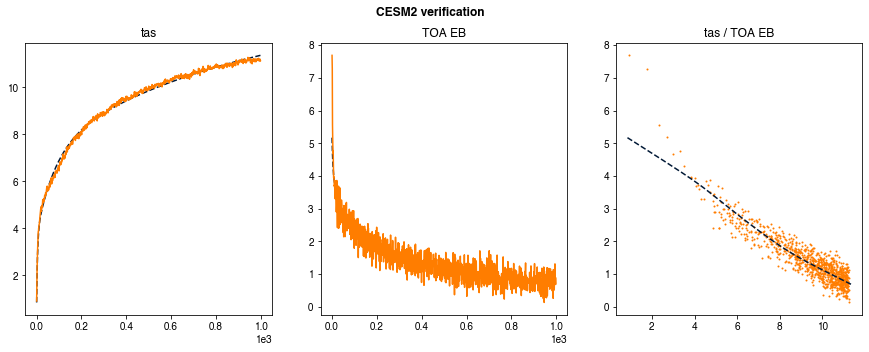

In [745]:
source = failed_sources[2]
plot_output=True

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [748]:
res_df.loc[:,source] = np.exp(fit_params.x)

fitting EC-Earth3-Veg
EC-Earth3-Veg fit converged


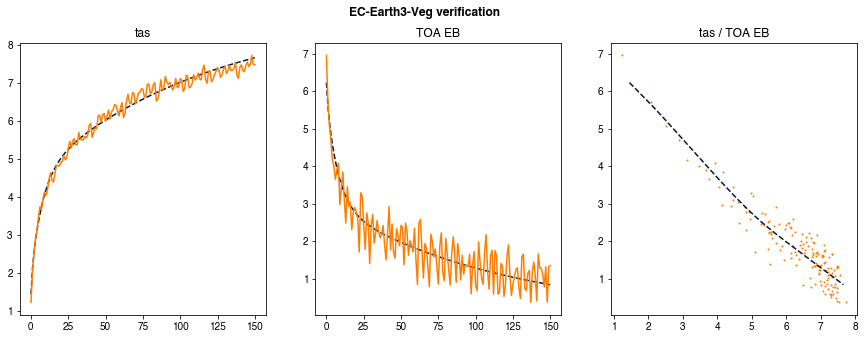

In [274]:
source = failed_sources[3]
plot_output=True

abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 1, 0.5, 0.5, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [275]:
res_df.loc[:,source] = np.exp(fit_params.x)

In [ ]:
source = failed_sources[4]
b, a = sp.signal.butter(2 , 0.3)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values),'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

fitting MIROC-ES2L
MIROC-ES2L fit converged


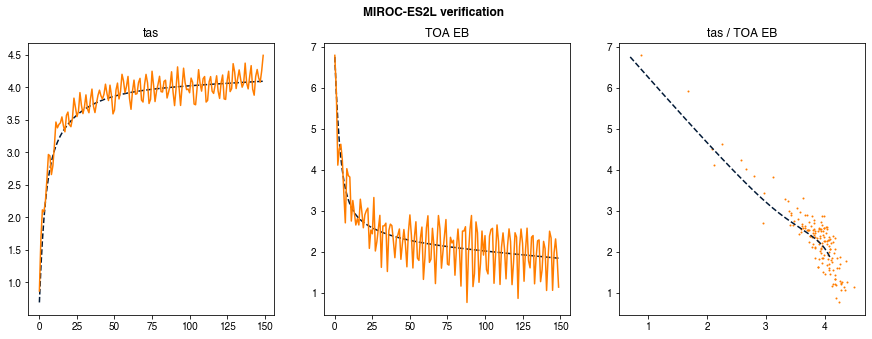

In [604]:
source = failed_sources[4]
plot_output=True

b, a = sp.signal.butter(2 , 0.2)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values[:-1]),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values[:-1])])

# abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values[:-1],-1*fit_data.loc[:,(source,'N')].dropna().values[:-1]])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

lb = np.log([0.1,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,0.4,0.1,0.1,4])
ub = np.log([4,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,100,3,3,13])
bounds = Bounds(lb,ub)

par0 = np.array([1.88697708e+00, 4.8, 14, 250, 1.926, 1.48, 0.78, 0.4 ,6.92283697e-01, 9.77460421e-01, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()

In [605]:
res_df.loc[:,source] = np.exp(fit_params.x)

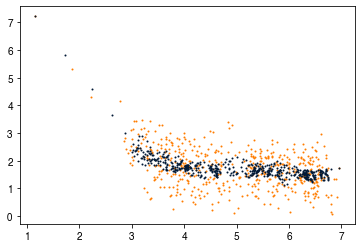

In [623]:
source = failed_sources[5]
b, a = sp.signal.butter(2 , 0.25)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values),'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

fitting NorESM2-LM
NorESM2-LM fit converged


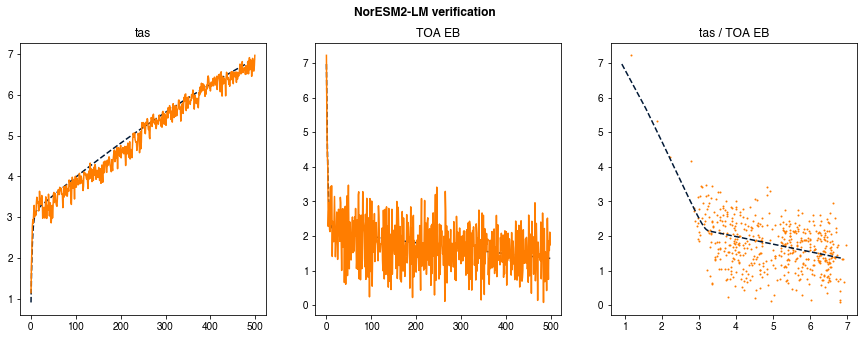

In [624]:
source = failed_sources[5]
plot_output=True

b, a = sp.signal.butter(2 , 0.25)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values),-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)])

# abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 50, 200, 0.4, 2.7, 3.2, 4, 0.5, 0.5, 8.5])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

print('fitting '+source)

lb = np.log([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,9.86])
ub = np.log([40,10,np.inf,2000,3,40,100,np.inf,3,1,9.87])
bounds = Bounds(lb,ub)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()
else:
    print(source+' fit failed')

In [625]:
res_df.loc[:,source] = np.exp(fit_params.x)

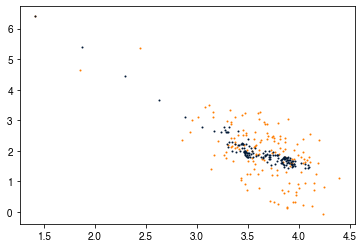

In [660]:
source = failed_sources[6]
b, a = sp.signal.butter(2 , 0.2)
plt.plot(sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values)[:-10],-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)[:-10],'o',ms=1)
plt.plot(fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values,'o',zorder=0,ms=1)

fitting NorESM2-MM
NorESM2-MM fit converged


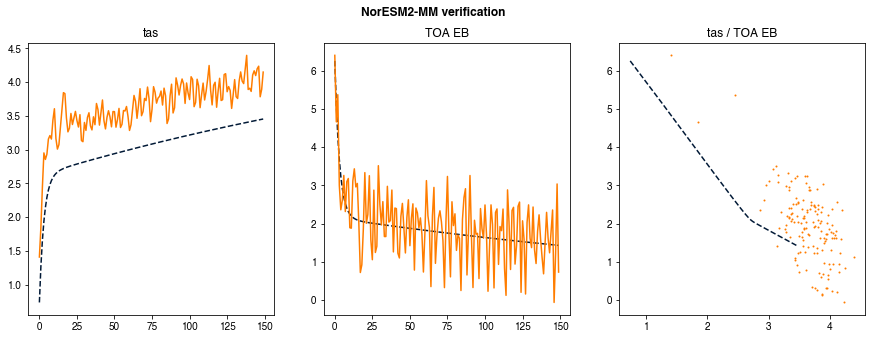

In [661]:
source = failed_sources[6]
plot_output=True

b, a = sp.signal.butter(2 , 0.2)
abrupt4x_yt = np.array([sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'tas')].dropna().values)[:-10],-1*sp.signal.filtfilt(b, a, fit_data.loc[:,(source,'N')].dropna().values)[:-10]])

# abrupt4x_yt = np.array([fit_data.loc[:,(source,'tas')].dropna().values,-1*fit_data.loc[:,(source,'N')].dropna().values])
    
# param_names = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx', 'F_2x', 'F_4x']

par0 = np.array([2, 5, 20, 100, 1, 2, 1, 2, 0.5, 0.5, 8])#np.insert(res_df[ism].values,-1,res_df[ism].values[-1]/2)

lb = np.log([1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1e-9,1,1e-9,1e-9,5])
ub = np.log([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,15])
bounds = Bounds(lb,ub)

print('fitting '+source)

fit_params = pdfo(lambda x: nll_abrupt4x(x,abrupt4x_yt,True)  ,x0=np.log(par0),bounds=bounds,method='bobyqa',options={'maxfev':20000})

if fit_params.success==1:
    print(source+' fit converged')

    if plot_output:
        visual_check_abrupt4x(source,np.exp(fit_params.x))
        plt.show()
        
else:
    print(source+' fit failed')

-55.95467198277147


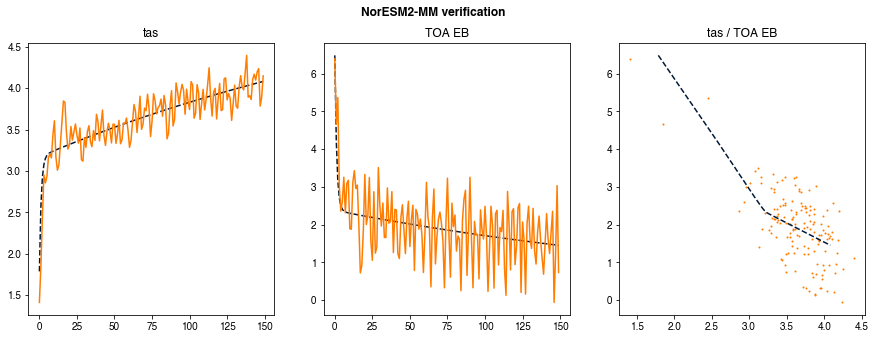

In [691]:
x = np.array([1.3830042,   4.1292158, 128.2617831  , 0.5880654   ,1.9660150,   1.4412264 ,  0.7009993, 207.4768558,   1.2269853 ,  0.7049990,  10.8311735])
visual_check_abrupt4x(source,x)
print(nll_abrupt4x(np.log(x),abrupt4x_yt,True))

In [ ]:
res_df.loc[:,source] = np.exp(fit_params.x)

## Checking the Cummins algorithm fits

In [15]:
cummins_results = pd.concat([pd.read_csv('../../../CMIP6_data_fitting/CMIP6_bias_corr_results/'+x+'.csv',usecols=[1]).iloc[:,0].rename(x) for x in fit_data.columns.levels[0]],axis=1)
cummins_results.index = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds','stdx', 'F_4x']

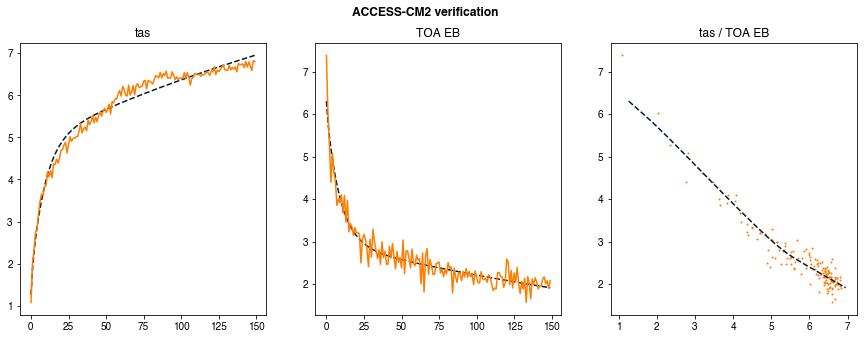

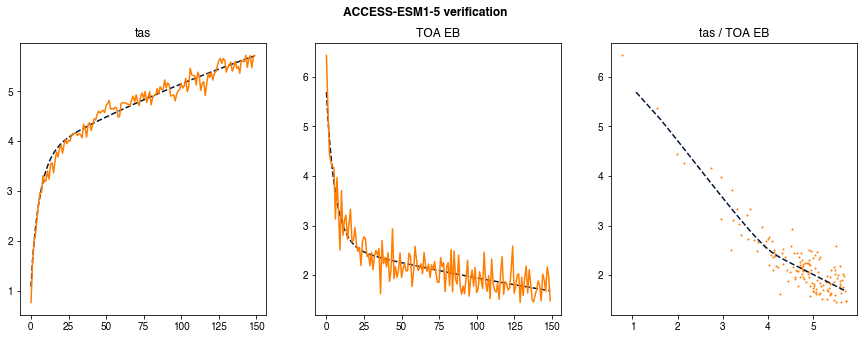

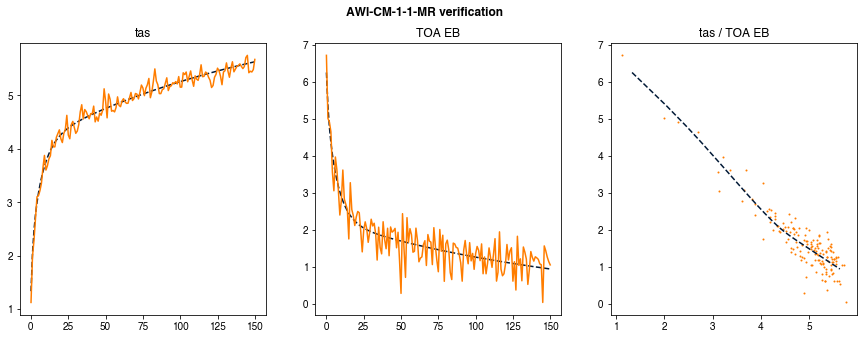

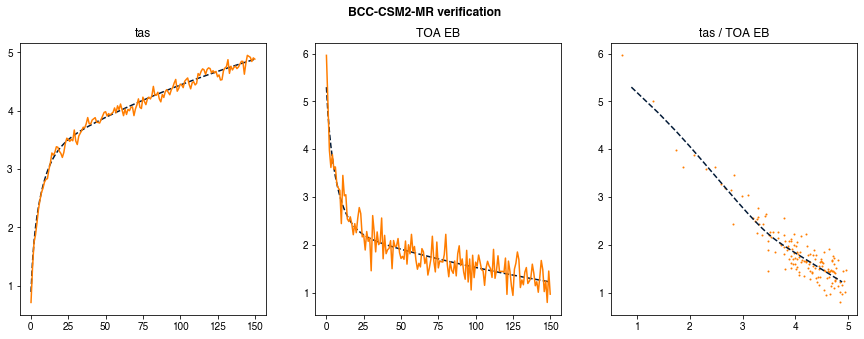

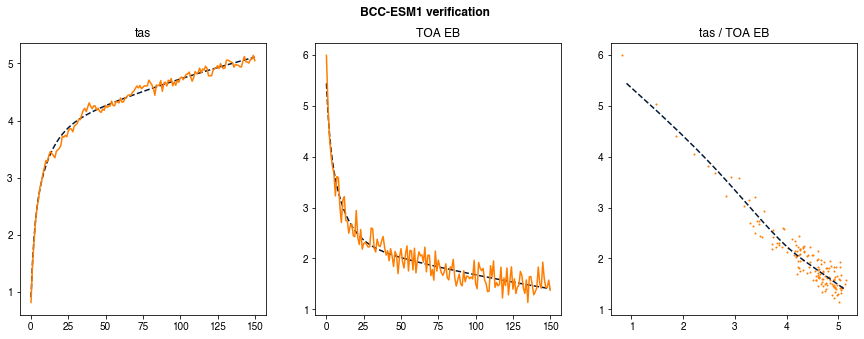

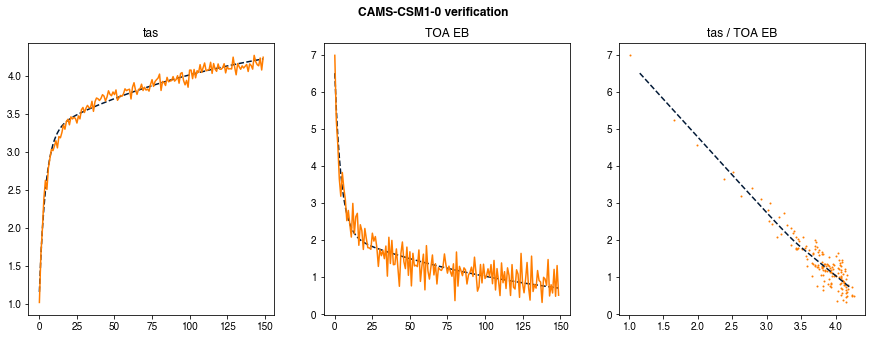

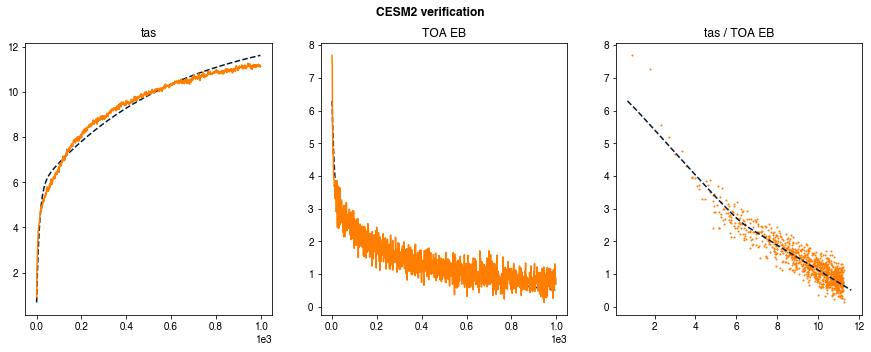

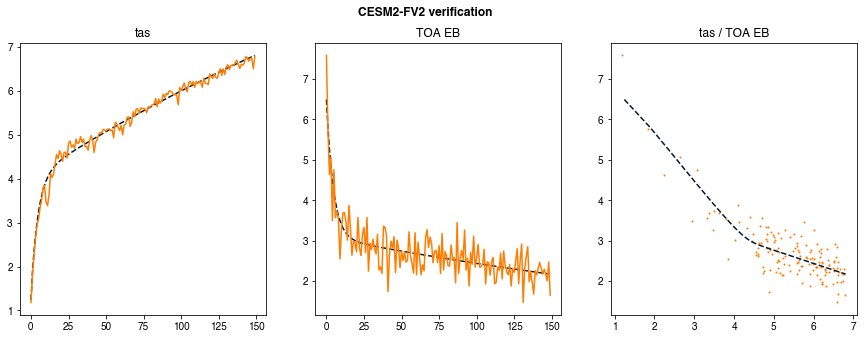

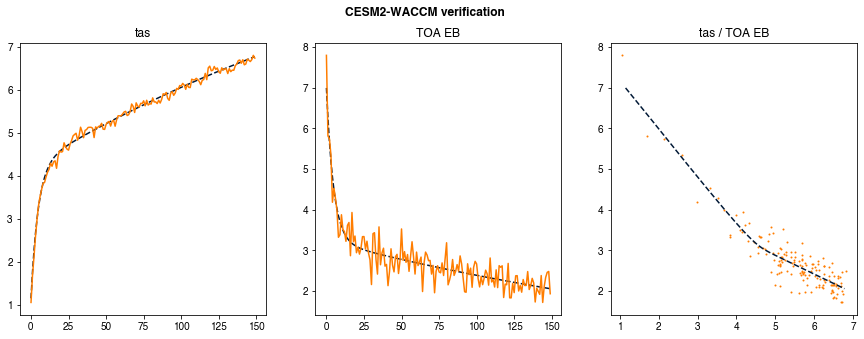

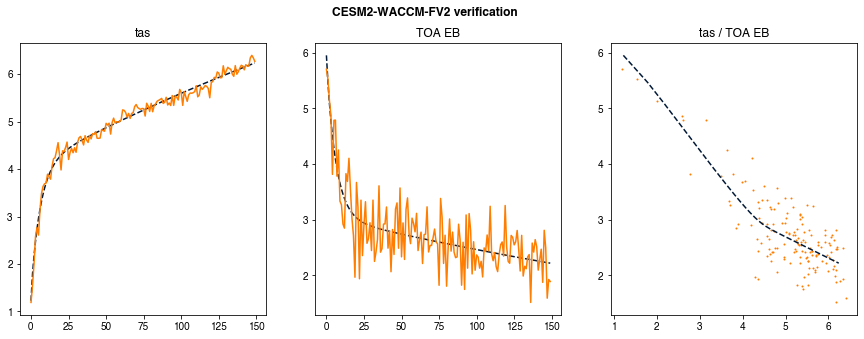

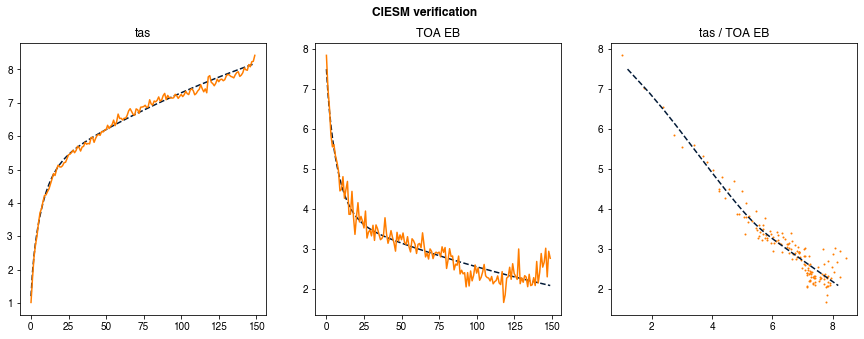

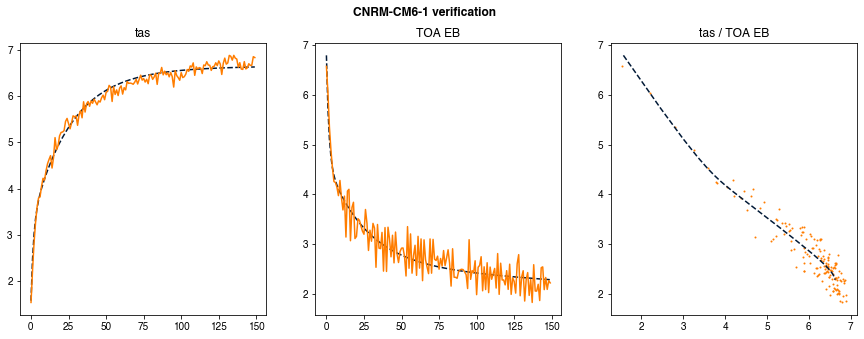

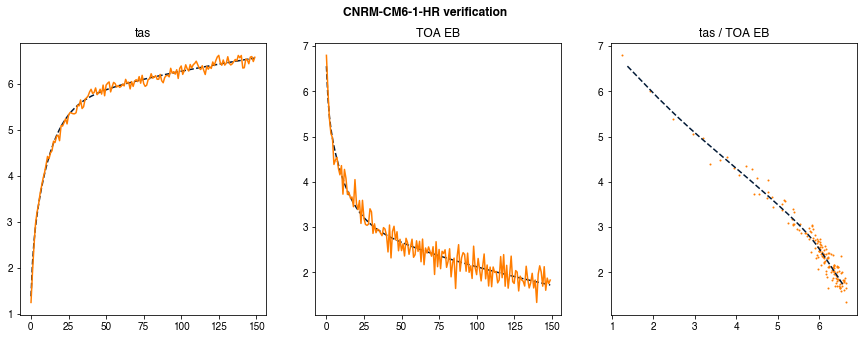

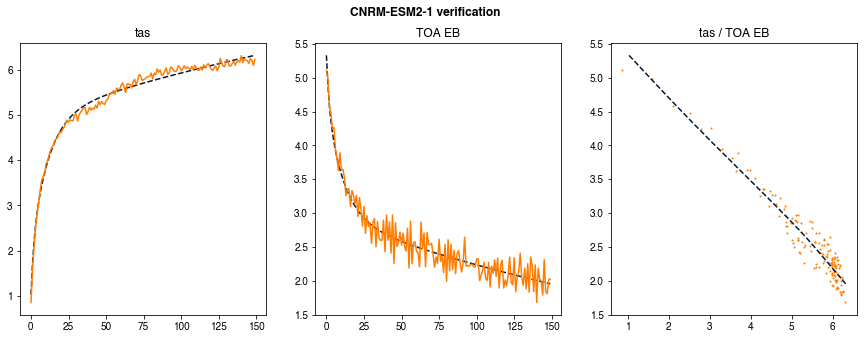

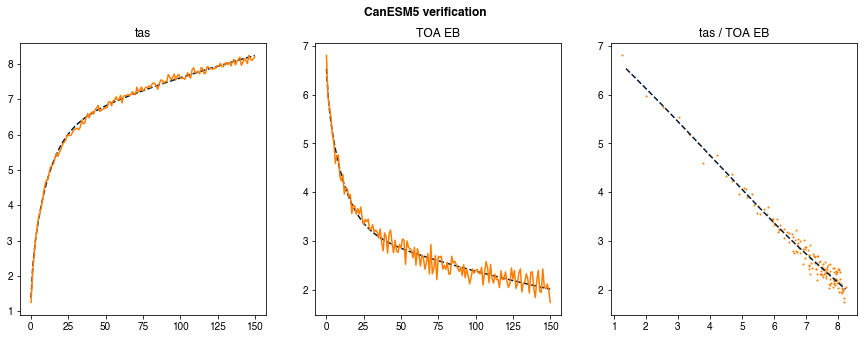

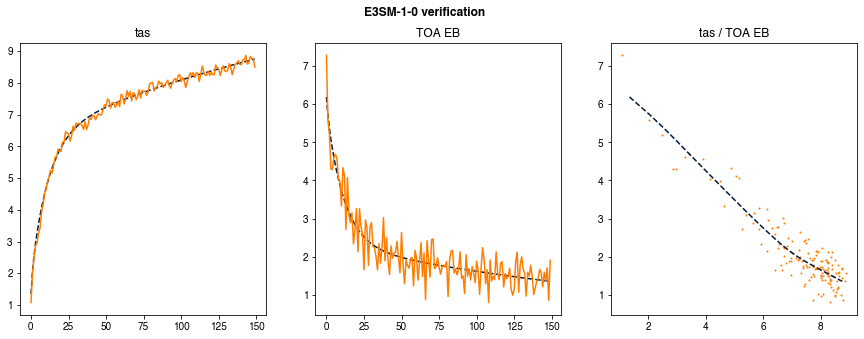

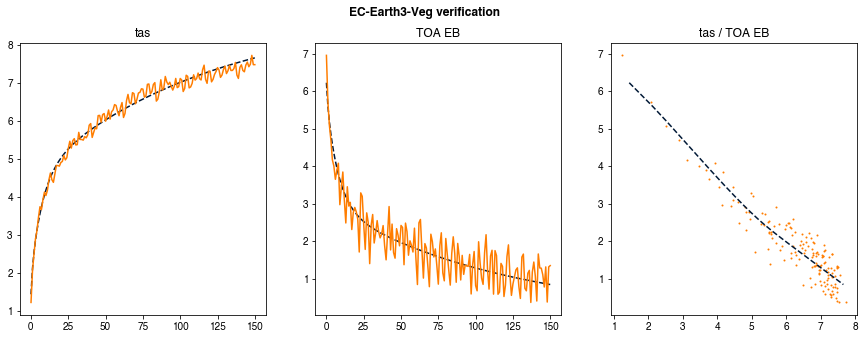

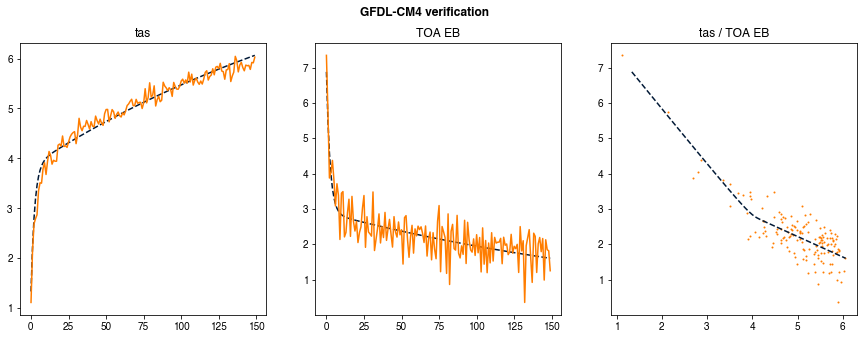

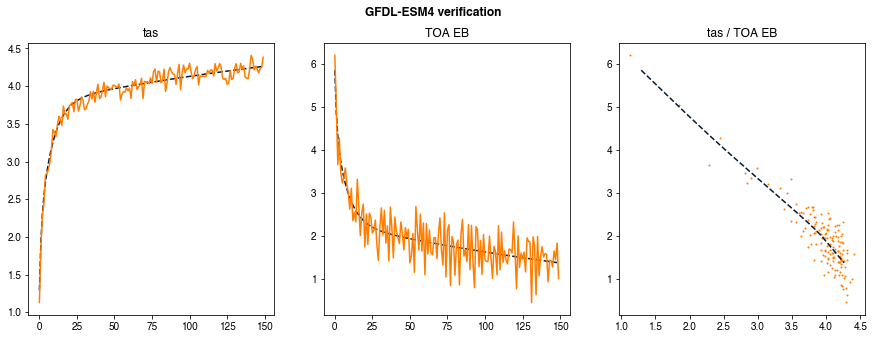

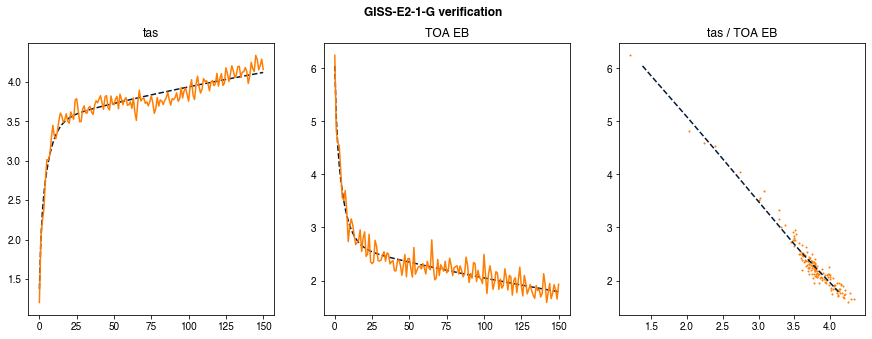

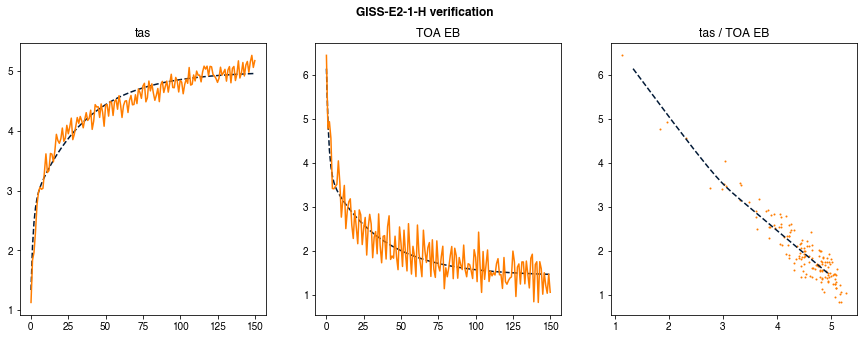

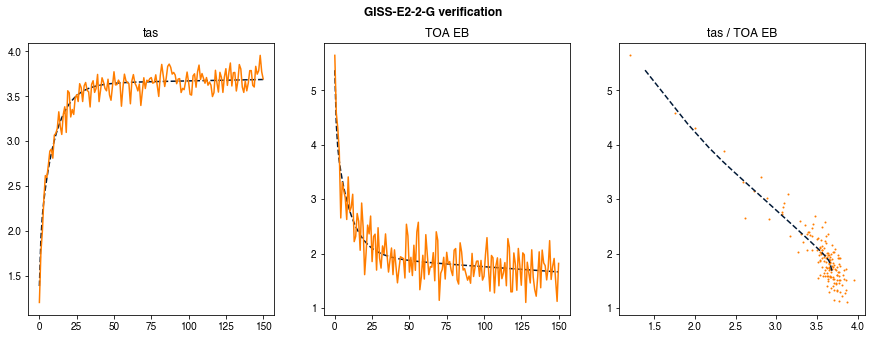

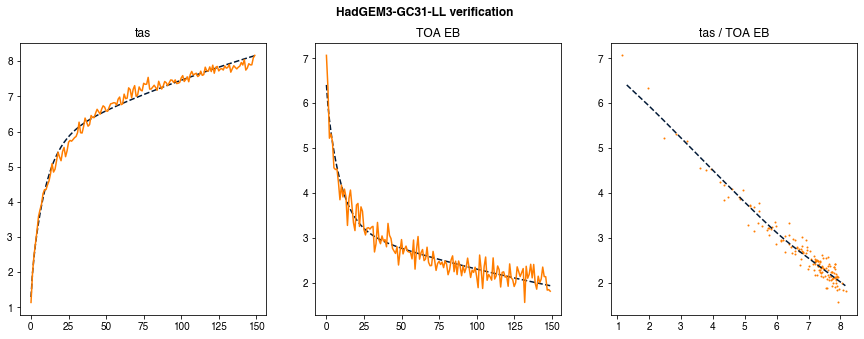

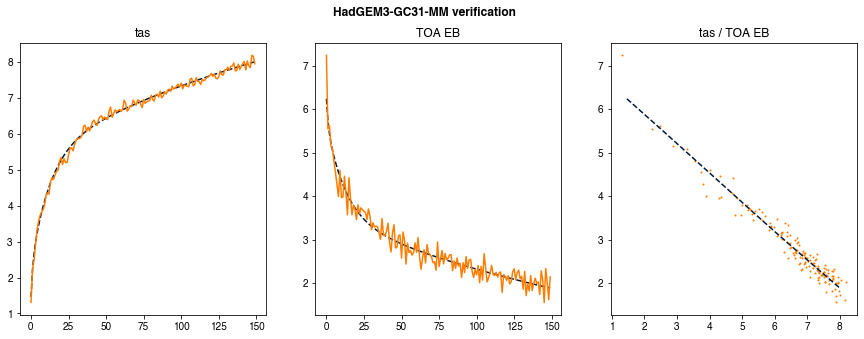

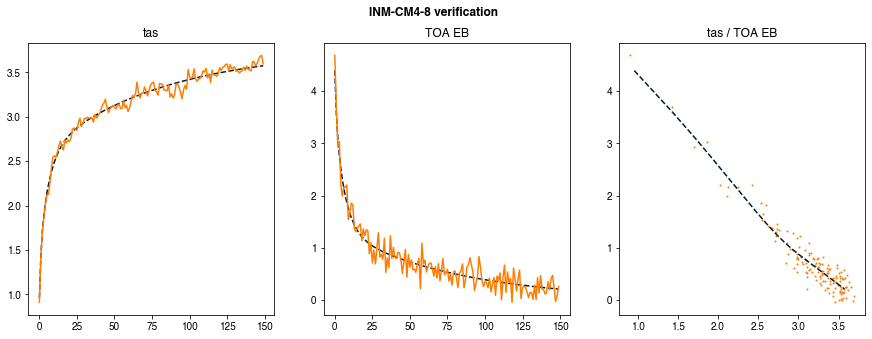

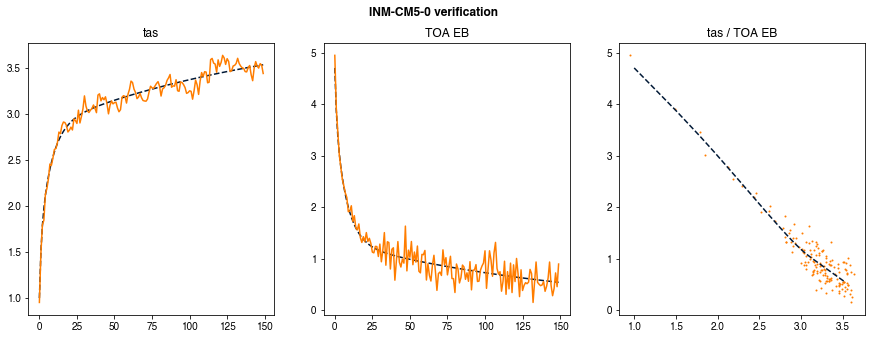

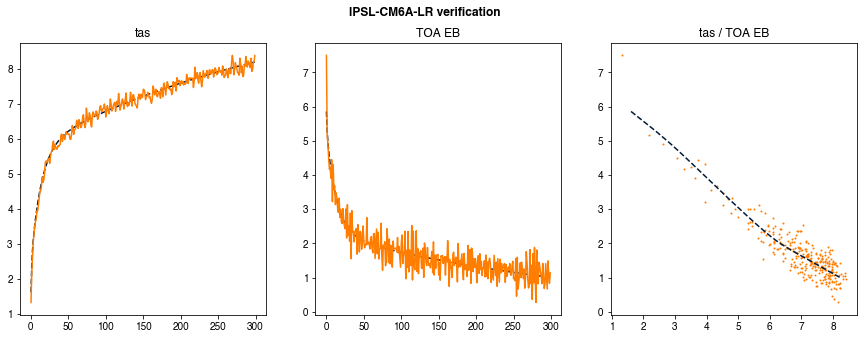

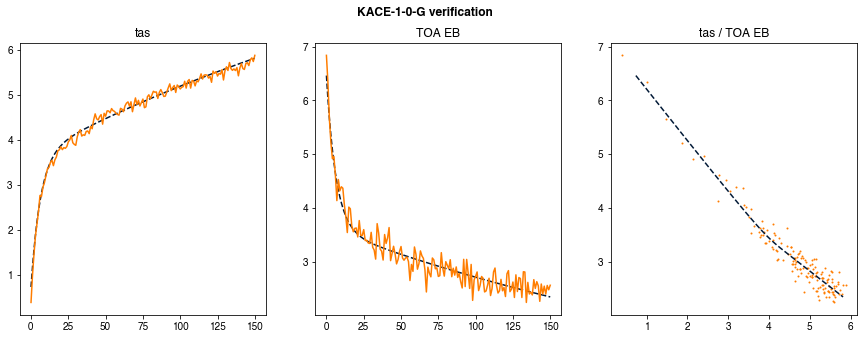

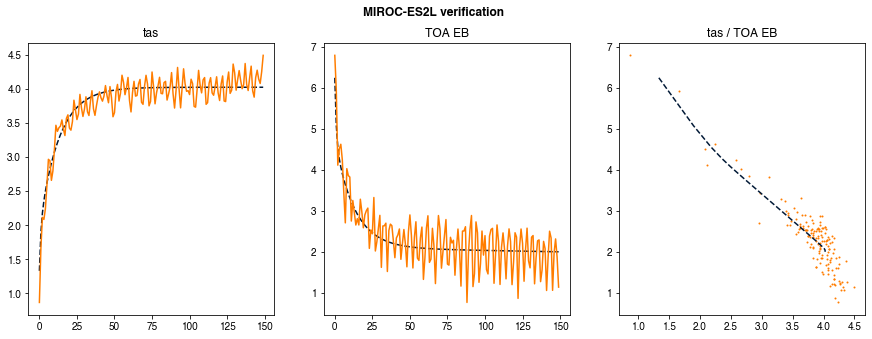

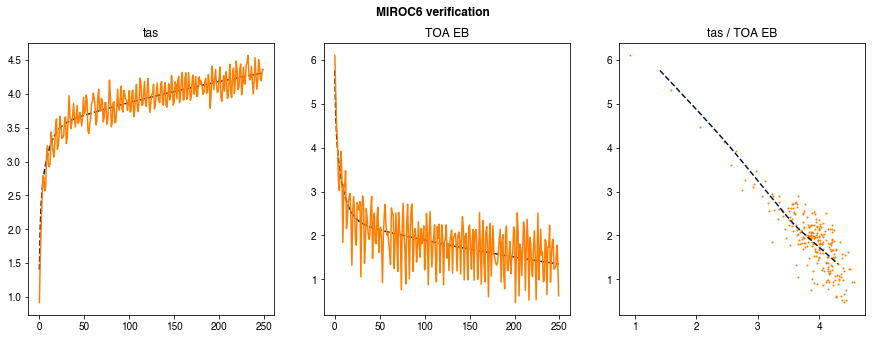

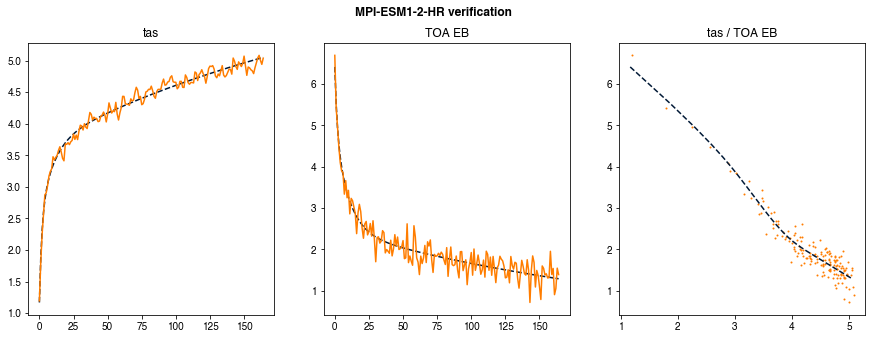

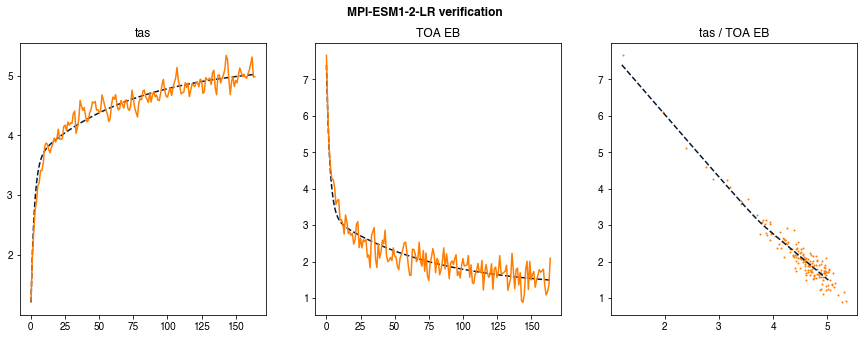

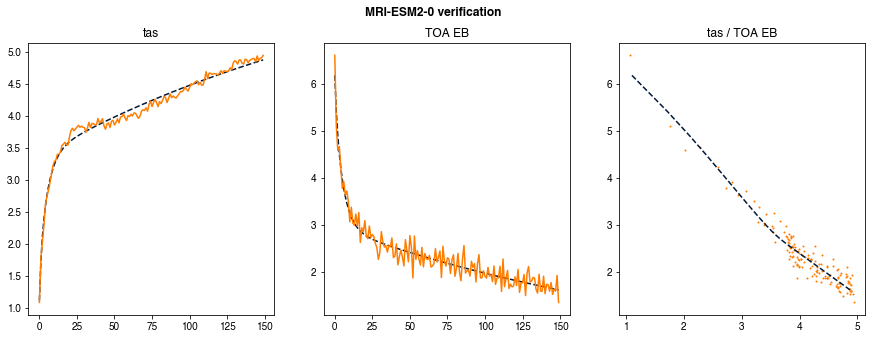

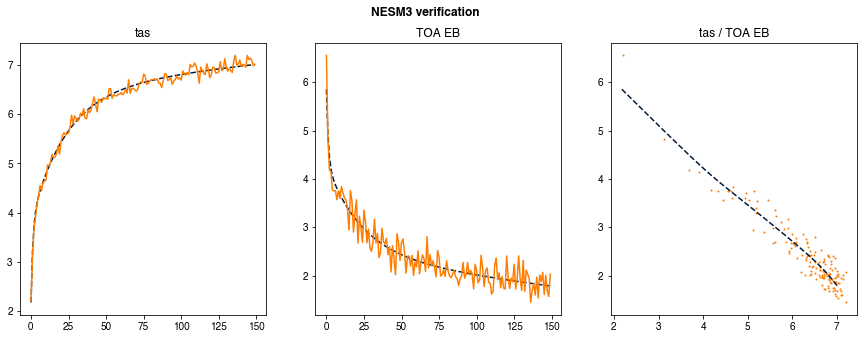

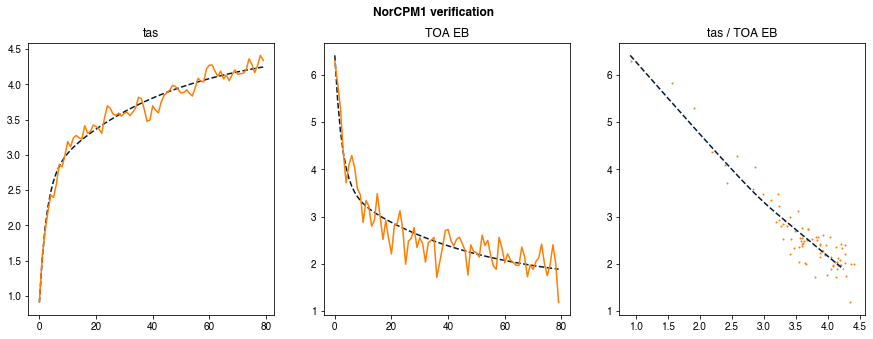

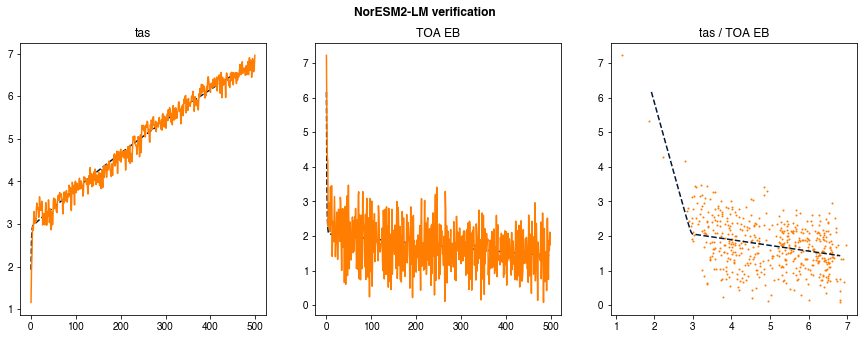

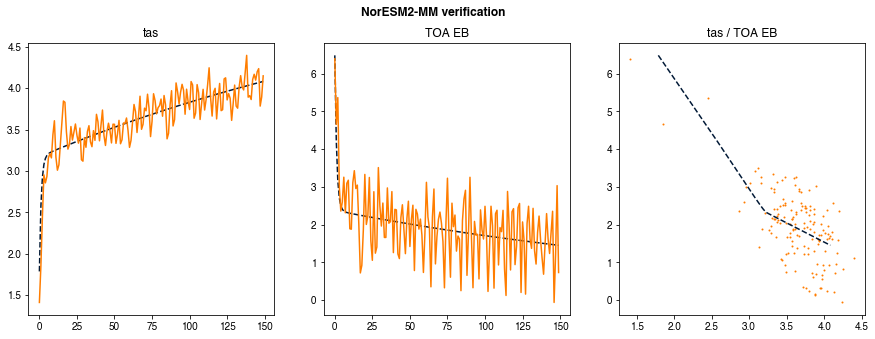

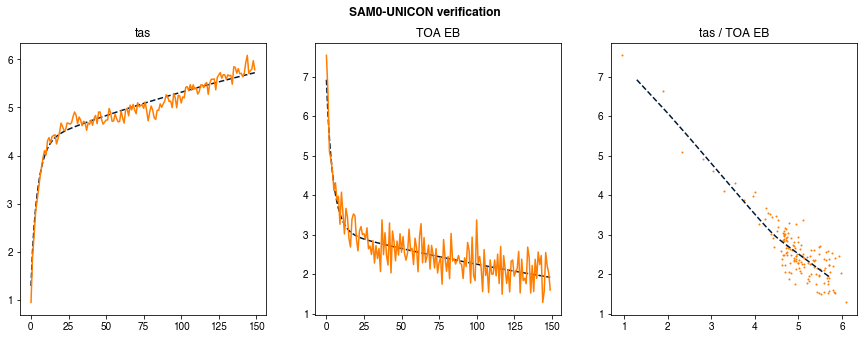

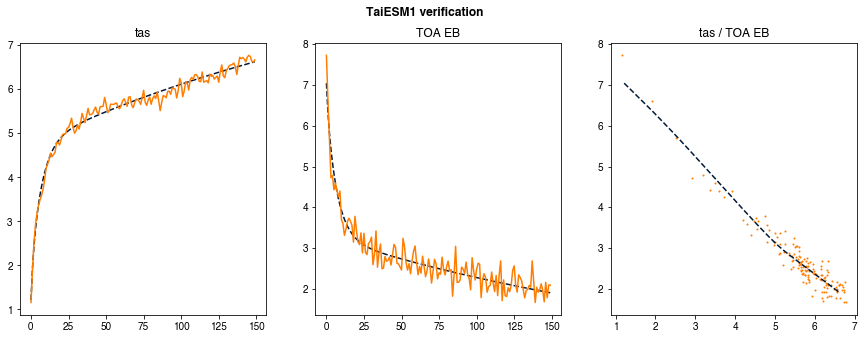

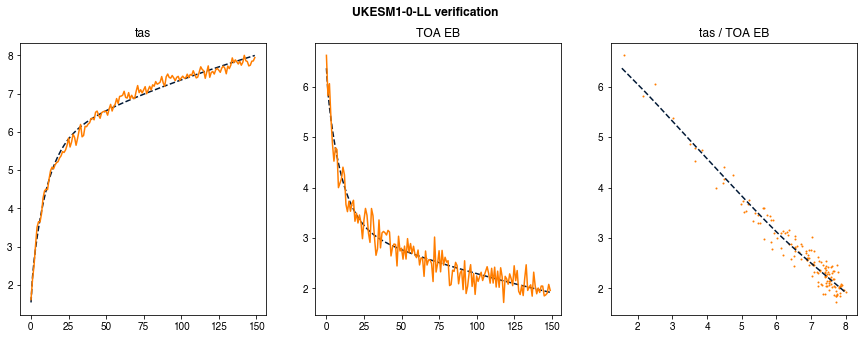

In [744]:
for source in fit_data.columns.levels[0]:
    visual_check_abrupt4x(source,cummins_results.loc[:,source])
    plt.show()

In [752]:
for source in list(res_df.columns):
    if source in ['CESM2','MIROC-ES2L']:
        continue
    res_df.loc[:,source] = cummins_results.loc[:,source].values

In [754]:
# res_df.to_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv')

## Estimating F_2x through measuring TCR

#### drift correction + baseline temp estimation

In [4]:
## let's get the baseline temps / drift slopes from the piControl:

def get_intercept_slope_tas(model,member,length):

    picontrol_member = cmip6_exp_info.loc['parent_variant',(model,member,'1pctCO2')]
    picontrol_tas = picontrol_data[model][picontrol_member]['tas'].dropna().astype(float)
    branch_point = cmip6_exp_info.loc['parent_branch_time_years',(model,member,'1pctCO2')]
    
    if (branch_point + length) < picontrol_tas.size:
        start = branch_point
        end = branch_point+length
        startidx = 0
        endidx=length
    else:
        if picontrol_tas.size < length:
            length = picontrol_tas.size
        start = picontrol_tas.size - length
        end = None
        startidx = start - branch_point
        endidx = start - branch_point + length
    
    _lr = sp.stats.linregress(np.arange(startidx,endidx),picontrol_tas.iloc[start:end])
    
    onepct_member = onepct_data[model][member]['tas'].dropna().values.astype(float)
    baseline_estimate = sp.stats.linregress(np.arange(1,26),onepct_member[:25]).intercept
    
    return baseline_estimate, _lr.slope

tas_baseline_slope_onepct = pd.DataFrame(index=['intercept','slope'],columns=onepct_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in onepct_data.xs('tas',axis=1,level=-1).columns:
    
    onepct_length = onepct_data[mod_mem[0]][mod_mem[1]].dropna().shape[0]
    
    if onepct_length<50:
        continue
    
    tas_baseline_slope_onepct.loc[:,mod_mem] = get_intercept_slope_tas(mod_mem[0],mod_mem[1],onepct_length)

In [5]:
## now we compute the drift corrected anomaly datasets:
onepct_data_corr = pd.DataFrame(index = list(np.arange(2000)), columns = onepct_data.xs('tas',axis=1,level=-1).columns)

for mod_mem in onepct_data.xs('tas',axis=1,level=-1).columns:
        
        mod_tas_data = onepct_data.loc[:,mod_mem].tas.astype(float).dropna()
        onepct_data_corr.loc[:mod_tas_data.size-1,(mod_mem)] = mod_tas_data.values - tas_baseline_slope_onepct.loc['intercept',mod_mem] - np.arange(mod_tas_data.size) * tas_baseline_slope_onepct.loc['slope',mod_mem]

In [121]:
TCR_values = onepct_data_corr.loc[60:79].mean().groupby(level=0).mean()

In [7]:
def convert_geoffrey_to_FaIR(params):
#     ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds', 'stdx','F_4x']

    A,b,Q,A_d,b_d,Q_d,C_d = BuildMat(params)
    eigval,eigvec = np.linalg.eig(A[1:,1:])
    tau = -1/eigval
    q = tau * ( eigvec[0,:] * np.linalg.inv(eigvec)[:,0] ) / params[1]
    
    return pd.DataFrame([tau,q],index=['d','q'],columns=[1,2,3])

In [10]:
res_df = pd.read_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv',index_col=0)

In [14]:
## Better way to fit F_2x based on observed TCR values:
res_df.loc['F_2x'] = np.nan

for model in res_df.columns:
    
    if model in TCR_values.index:

        fair_params = convert_geoffrey_to_FaIR(res_df.loc[:,model].iloc[:10])

        res_df.loc['F_2x',model] = TCR_values.loc[model]/( fair_params.loc['q'] * (1 - (fair_params.loc['d']/70) * ( 1 - np.exp(-70/fair_params.loc['d']) ) ) ).sum()
        
    else:
        continue#res_df.loc['F_2x',model] = res_df.loc['F_4x',model] /2

In [20]:
res_df.to_csv('../Parameter_Sets/CMIP6_stoch_Geoffrey_response.csv')

## Fitting carbon cycle parameters to 1pctCO2 runs

In [8]:
## get emissions / temp data for onepct runs

model_listing = [x for x in glob.glob('/home/leachl/Documents/Datasets/CMIP6/CMIP6_TCRE/CMIP6_TCRE/*') if 'data.txt' in x]
models =  [x.split('/')[-1].split('_')[0] for x in model_listing]
model_1pct = pd.concat([pd.read_csv(x,delim_whitespace=True,header=None,names=['year','E','T'],index_col=0) for x in model_listing],axis=1,keys=models)
model_1pct.columns.set_levels(['BCC-CSM2-MR','CNRM-ESM2-1','UKESM1-0-LL','CanESM5','MIROC-ES2L','MPI-ESM1-2-LR','IPSL-CM6A-LR'],level=0,inplace=True) 

In [9]:
## get co2 data
co2data = pd.read_csv('../tools/cmip6_data/co2.csv',index_col=0)
co2data.columns = pd.MultiIndex.from_tuples([tuple(x.split('_')) for x in  co2data.columns])
co2data = co2data.xs('1pctCO2',axis=1,level=-1).droplevel((0,3),axis=1)

## get co2 data
co2massdata = pd.read_csv('../tools/cmip6_data/co2mass.csv',index_col=0)
co2massdata.columns = pd.MultiIndex.from_tuples([tuple(x.split('_')) for x in  co2massdata.columns])
co2massdata = co2massdata.xs('1pctCO2',axis=1,level=-1).droplevel((0,3),axis=1)

co2data = co2data.groupby(axis=1,level=0).mean().loc[:,[x for x in co2data.columns.levels[0] if x in model_1pct.columns.levels[0]]]

co2massdata = co2massdata.groupby(axis=1,level=0).mean().loc[:,[x for x in co2massdata.columns.levels[0] if x in model_1pct.columns.levels[0]]]

conc_data = pd.DataFrame(index = np.arange(400),columns = model_1pct.columns.levels[0])

for model in co2massdata.columns:
    model_data = co2massdata[model].dropna() / (5.1480 * 10e11) * 28.97 / 44.01
    conc_data.loc[:model_data.size-1,model] = model_data.values
    
for model in co2data.columns:
    model_data = co2data[model].dropna() * 1e6
    conc_data.loc[:model_data.size-1,model] = model_data.values
    
conc_data.loc[:,['CanESM5','MIROC-ES2L']] = np.array([conc_data.mean(axis=1)]*2).T

In [13]:
old_cc_tunings = pd.read_csv('../Parameter_Sets/CMIP6_1pctCO2_cc.csv',index_col=0)
old_cc_tunings.index = ['UKESM1-0-LL','MIROC-ES2L','IPSL-CM6A-LR','BCC-CSM2-MR','CNRM-ESM2-1','CanESM5','MPI-ESM1-2-LR']
old_cc_tunings

beta  gamma         r0        rC        rT  PI_co2
UKESM1-0-LL    0.63   1.31  37.501757  0.016319  3.577207   282.4
MIROC-ES2L     0.68   1.20  34.352755  0.016135  3.536897   286.9
IPSL-CM6A-LR   0.95   1.00  28.627296  0.018784  4.117711   290.0
BCC-CSM2-MR    0.64   1.07  30.631206  0.013540  2.968220   288.9
CNRM-ESM2-1    0.50   1.22  34.925301  0.012061  2.644004   290.2
CanESM5        0.23   1.27  36.356665  0.005776  1.266088   285.5
MPI-ESM1-2-LR  0.76   1.20  34.352755  0.018033  3.953003   285.9

In [14]:
GIR_default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)['carbon_dioxide'].apply(pd.to_numeric)
a = GIR_default_params.loc['a1':'a4'].values
tau = GIR_default_params.loc['tau1':'tau4'].values
r = np.array([32.4,0.019,4.165,0])
PI_conc = GIR_default_params.loc['PI_conc']
emis2conc = GIR_default_params.loc['emis2conc']

def tune_cc(r,PI_conc,C,T,E):
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0] = emissions.loc[1]/2
    cost1 = (emissions.values - E)#.rolling(20).mean().loc[[39,59,79,99,119,139]].values / abs(pd.Series(E)).sum()
    _yp = emissions.diff()
    _y = pd.Series(E).diff()
    cost2 = (_y-_yp).rolling(20).mean().loc[[39,59,79,99,119,139]].values / abs(_y).sum()
    
    return np.sum(cost1**2)

def verify_tuning(ax,C,T,E,r,PI_conc,model='unspecified',plot_source=True,color='green'):
    
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0]=emissions.loc[1]/2
    ax[0].plot(emissions.values,'--',c=color)
    ax[1].plot((emissions.values-E)/emissions.mean(),c=color)
    ax[2].plot(emissions.cumsum().values,'--',c=color)
    ax[3].plot((emissions.cumsum().values-np.cumsum(E))/emissions.cumsum().mean(),zorder=0,c=color)
    ax[4].plot(emissions.cumsum().values,C,'--',c=color)
    
    if plot_source:
        ax[0].plot(E,zorder=0)
        ax[2].plot(np.cumsum(E),zorder=0)
        ax[4].plot(np.cumsum(E),C,zorder=0)
        ax[1].axhline(0,color='k',alpha=0.5,lw=0.5)
        ax[3].axhline(0,color='k',alpha=0.5,lw=0.5)

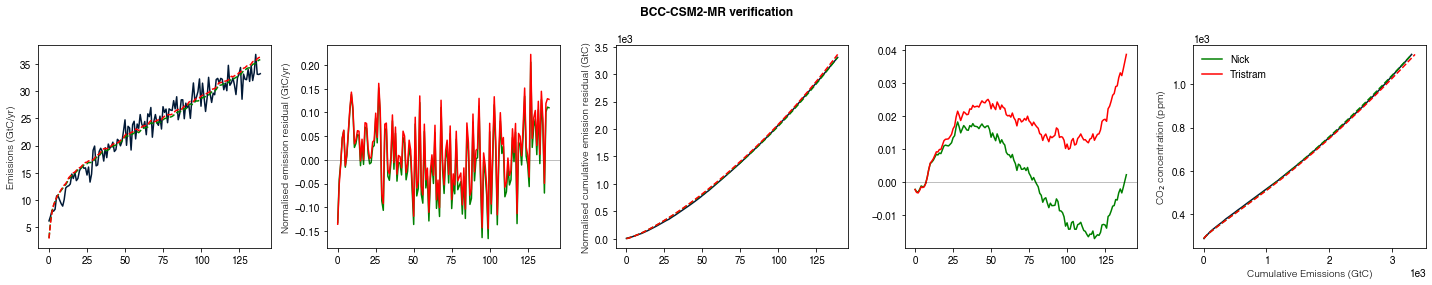

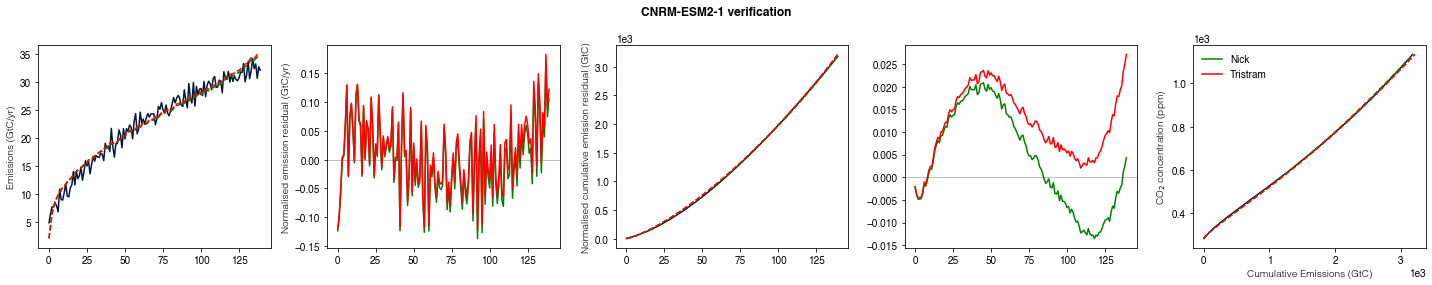

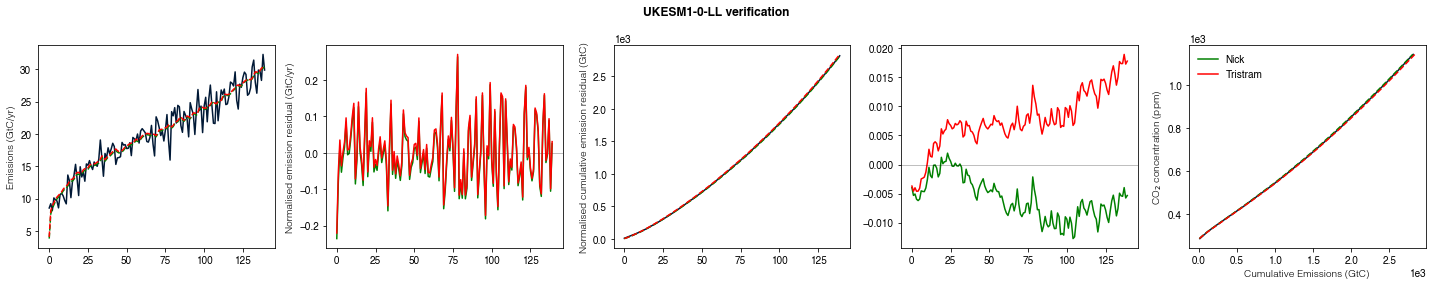

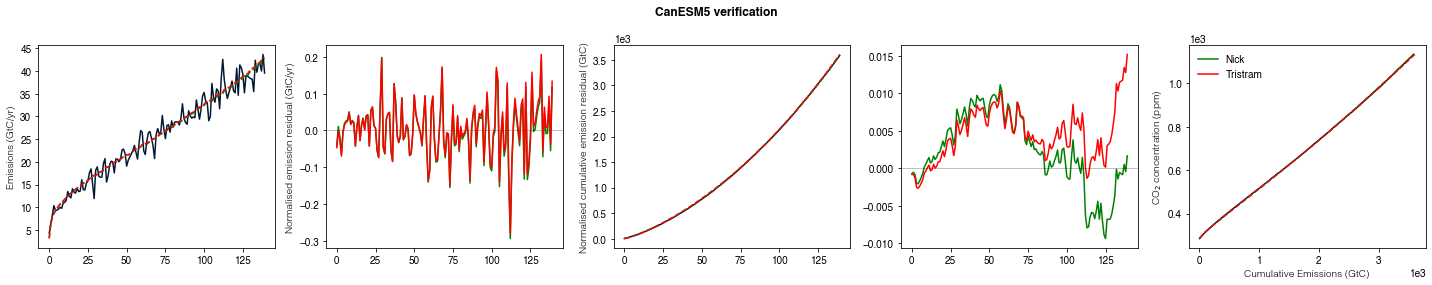

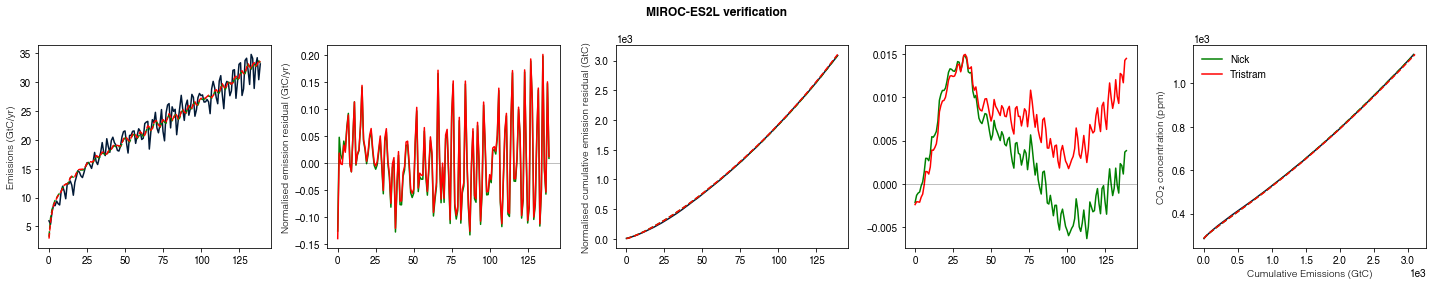

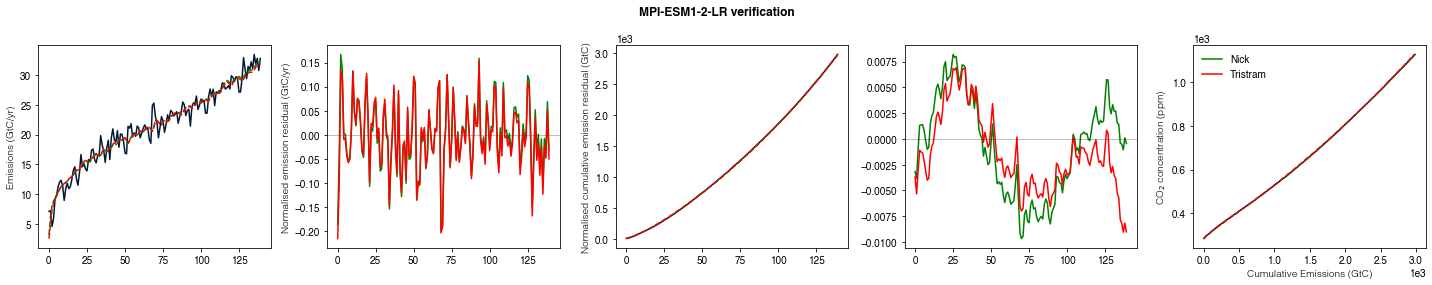

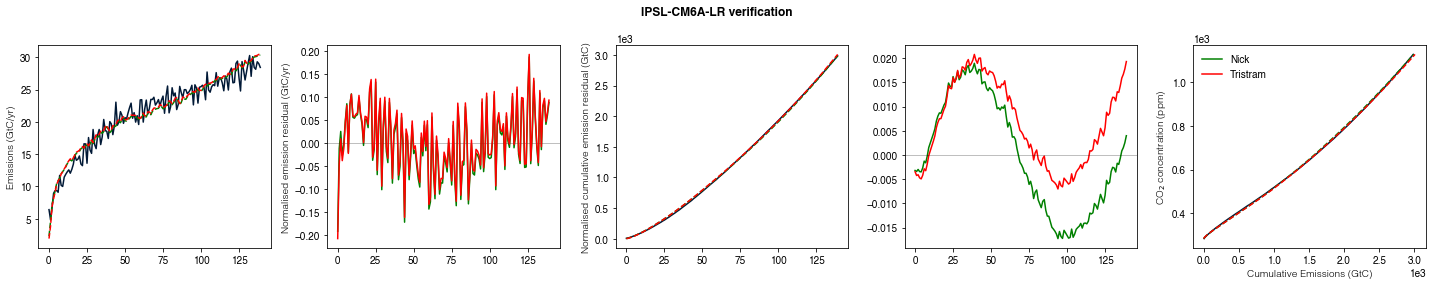

In [15]:
cc_tuning_results_df = pd.DataFrame(index = conc_data.columns,columns=['r0','rC','rT','PI_conc'])

for model in cc_tuning_results_df.index:

    C = conc_data[model].dropna().values
    cumE = model_1pct[model]['E'].dropna().values
    E = np.diff(np.concatenate(([0],cumE),axis=0))
    T = model_1pct[model]['T'].dropna().values

    min_length = np.array([C.size,E.size,T.size]).min()
    C = C[:min_length]
    E = E[:min_length]
    T = T[:min_length]

    from pdfo import Bounds

    lb = [20,0,270]
    ub = [45,0.05,300]
    bounds = Bounds(lb,ub)

    results = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[1]/0.019*4.165,0]),x[2],C,T,E),x0=[30,0.02,280],method='bobyqa',bounds=bounds,options={'npt':10})
    
    fig,ax = plt.subplots(1,5,figsize=(20,4))
    
    r_test = np.array([results.x[0],results.x[1],results.x[1]/0.019*4.165,0])
    verify_tuning(ax,C,T,E,r_test,results.x[2],model=model)
    
    r_test = np.array(old_cc_tunings.loc[model,['r0','rC','rT']].tolist()+[0])
    verify_tuning(ax,C,T,E,r_test,old_cc_tunings.loc[model,'PI_co2'],model=model,plot_source=False,color='red')
    
    ax[4].plot([],[],c='green',label='Nick')
    ax[4].plot([],[],c='red',label='Tristram')
    
    ax[4].legend()
    
    plt.tight_layout()
    plt.show()
    
    cc_tuning_results_df.loc[model] = [results.x[0],results.x[1],results.x[1]/0.019*4.165,results.x[2]]

In [302]:
# cc_tuning_results_df.to_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_12082020.csv')

In [261]:
old_cc_tunings

beta  gamma         r0        rC        rT  PI_co2
UKESM1-0-LL    0.63   1.31  37.501757  0.016319  3.577207   282.4
MIROC-ES2L     0.68   1.20  34.352755  0.016135  3.536897   286.9
IPSL-CM6A-LR   0.95   1.00  28.627296  0.018784  4.117711   290.0
BCC-CSM2-MR    0.64   1.07  30.631206  0.013540  2.968220   288.9
CNRM-ESM2-1    0.50   1.22  34.925301  0.012061  2.644004   290.2
CanESM5        0.23   1.27  36.356665  0.005776  1.266088   285.5
MPI-ESM1-2-LR  0.76   1.20  34.352755  0.018033  3.953003   285.9

In [16]:
cc_tuning_results_df

r0          rC       rT  PI_conc
BCC-CSM2-MR    31.5848   0.0138062  3.02646  288.289
CNRM-ESM2-1    35.0688   0.0124555  2.73039  290.498
UKESM1-0-LL    38.4436   0.0162739   3.5674  283.609
CanESM5        36.3074  0.00599149   1.3134  284.747
MIROC-ES2L     34.9695   0.0160563  3.51971  285.276
MPI-ESM1-2-LR  35.6397   0.0169906  3.72452  282.701
IPSL-CM6A-LR   29.3354   0.0188078  4.12286  288.537

## Using bgc runs to diagnose rT / rC

In [205]:
## Import Arora (2020) data

fnames = ['/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/JAMSTEC/JAMSTEC_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/ACCESS-ESM1.5/ACCESS-ESM1.5_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CNRM-ESM2.1/CNRM-ESM2.1_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/IPSL/IPSL_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CanESM5/CanESM5_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/GFDL/GFDL_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/MPIESM/MPIESM_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/CESM2/CESM2_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_1pc_COU.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_1pc_BGC.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_1pc_RAD.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/BCC/BCC_PI_CONTROL.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_PI_CONTROL_v2.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_BGC_v2.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_RAD_v2.txt',
 '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/NorESM2LM/NorESM2LM_1pc_COU_v2.txt']

def get_C4MIP_data(x):
    if x == '/home/leachl/Documents/Datasets/CMIP6/carbon_feedback_analysis_C4MIP_for_CMIP6_for_Zeb_Malte_Jared/model_output_cmip6/UKESM/UKESM_PI_CONTROL.txt':
        return pd.read_csv(x,delim_whitespace=True,index_col=0,skiprows=1,names=['year','ST','CO2','LA_CO2_FLUX','OA_CO2_FLUX','GPP','NPP','HETRES','CLIVE','CDEAD'])
    else:
        return pd.read_csv(x,delim_whitespace=True,index_col=0)
C4MIP_data = pd.concat([get_C4MIP_data(x) for x in fnames],axis=1,keys=['.'.join(x.split('/')[-1].split('.')[0:-1]) for x in fnames])

In [683]:
map_models = dict(zip(['JAMSTEC','ACCESS-ESM1.5','CNRM-ESM2.1','IPSL','CanESM5','GFDL','MPIESM','CESM2','UKESM','BCC','NorESM2LM'],\
                   ['MIROC-ES2L','ACCESS-ESM1-5','CNRM-ESM2-1','IPSL-CM6A-LR','CanESM5','GFDL-ESM4','MPI-ESM1-2-LR','CESM2','UKESM1-0-LL','BCC-CSM2-MR','NorESM2-LM']))

map_exp = dict(zip(['COU','BGC','RAD','CONTROL'],['1pctCO2','1pctCO2-bgc','1pctCO2-rad','piControl']))

map_flux_direction = dict(zip(map_models.keys(),[1,-1,1,1,1,1,-1,1,-1,-1,-1]))

C4MIP_data_1 = pd.DataFrame(columns=pd.MultiIndex.from_product([list(map_models.values()),['1pctCO2','1pctCO2-bgc','1pctCO2-rad','piControl'],['tas','CO2','flux']]),index=np.arange(0,151))

def dedrift_data(data,picontrol):
    drift = sp.stats.linregress(np.arange(1,picontrol.size+1),picontrol).slope
    intercept = sp.stats.linregress(np.arange(1,21),data[:20]).intercept
    return data - drift*np.arange(data.size) - intercept

for modmem in C4MIP_data.columns.levels[0]:
    exp = modmem.split('_')[2]
    model = modmem.split('_')[0]
    currdata = C4MIP_data.loc[:,modmem].dropna(how='all')
    
    ## get tas + baseline, DON'T de-drift since this is what the model actually experienced...
    picontrol_idx = model+'_PI_CONTROL' + (model=='NorESM2LM')*'_v2'
    
    C4MIP_data_1.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'tas')] = currdata.loc[:,'ST'].values - sp.stats.linregress(np.arange(1,21),currdata.loc[:,'ST'].values[:20]).intercept#dedrift_data(currdata.loc[:,'ST'].values,C4MIP_data.loc[:,(picontrol_idx,'ST')].dropna().values)
    
    C4MIP_data_1.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'CO2')] = currdata.loc[:,'CO2'].values
    
    # Pierre didn't de-drift the flux data...
    C4MIP_data_1.loc[:currdata.shape[0]-1,(map_models[model],map_exp[exp],'flux')] = map_flux_direction[model]*(currdata.loc[:,'OA_CO2_FLUX'].values+currdata.loc[:,'LA_CO2_FLUX'].values - np.mean(C4MIP_data.loc[:,(picontrol_idx,'OA_CO2_FLUX')].dropna().values+C4MIP_data.loc[:,(picontrol_idx,'LA_CO2_FLUX')].dropna().values))#dedrift_data(currdata.loc[:,'OA_CO2_FLUX'].values,C4MIP_data.loc[:,(picontrol_idx,'OA_CO2_FLUX')].dropna().values) + dedrift_data(currdata.loc[:,'LA_CO2_FLUX'].values,C4MIP_data.loc[:,(picontrol_idx,'LA_CO2_FLUX')].dropna().values)
    
C4MIP_data_1.drop('piControl',axis=1,level=1,inplace=True)

In [753]:
GIR_default_params = pd.read_csv('../Parameter_Sets/Complete_gas_cycle_params.csv',skiprows=1,index_col=0)['carbon_dioxide'].apply(pd.to_numeric)
a = GIR_default_params.loc['a1':'a4'].values
tau = GIR_default_params.loc['tau1':'tau4'].values
r = np.array([32.4,0.019,4.165,0])
PI_conc = GIR_default_params.loc['PI_conc']
emis2conc = GIR_default_params.loc['emis2conc']

def tune_cc(r,PI_conc,C,T,E,cost='both',rate_weight=1,cum_weight=1):
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0] = 0
    rate_res = (emissions.values[1:] - E[1:])#.rolling(20).mean().loc[[39,59,79,99,119,139]].values / abs(pd.Series(E)).sum()
    _yp = emissions.diff()
    _y = pd.Series(E).diff()
    cum_res = np.cumsum(emissions.values) - np.cumsum(E)
    
    cost1 = np.sqrt(np.mean(rate_res**2))/rate_weight
    cost2 = np.sqrt(np.mean(cum_res**2))/cum_weight
    
    if cost == 'both':
        return cost1+cost2#(np.sum(rate_res**2)/np.sum(E[1:]) + np.sum(cum_res**2)/np.sum(np.cumsum(E)))/2
    if cost == 'rate':
        return cost1#np.sum(rate_res**2)/np.sum(E[1:])
    if cost == 'rate_residual_variance':
        return np.var(cost1)
    if cost == 'cumulative':
        return cost2#np.sum(cum_res**2)/np.sum(np.cumsum(E))

def verify_tuning(ax,C,T,E,r,PI_conc,plot_over=True,color='green'):
    
    emissions = invert_carbon_cycle_prescribed_T(C,T,a,tau,r,PI_conc,emis2conc).rolling(2).mean()
    emissions.loc[0] = 0
    ax[0].plot(emissions.values,'--',c=color)
    ax[1].plot((emissions.values-E),c=color)
    ax[2].plot(emissions.cumsum().values,'--',c=color)
    ax[3].plot((emissions.cumsum().values-np.cumsum(E)),zorder=0,c=color)
    ax[4].plot(emissions.cumsum().values,C,'--',c=color)
    
    if plot_over:

        ax[0].plot(E,zorder=0)
        ax[2].plot(np.cumsum(E),zorder=0)
        ax[4].plot(np.cumsum(E),C,zorder=0)
        ax[1].axhline(0,color='k',alpha=0.5,lw=0.5)
        ax[3].axhline(0,color='k',alpha=0.5,lw=0.5)

        ax[0].set_ylabel('Emissions (GtC/yr)')
        ax[1].set_ylabel('Normalised emission residual (GtC/yr)')
        ax[2].set_ylabel('Cumulative Emissions (GtC)')
        ax[2].set_ylabel('Normalised cumulative emission residual (GtC)')
        ax[4].set_xlabel('Cumulative Emissions (GtC)')
        ax[4].set_ylabel('CO$_2$ concentration (ppm)')

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


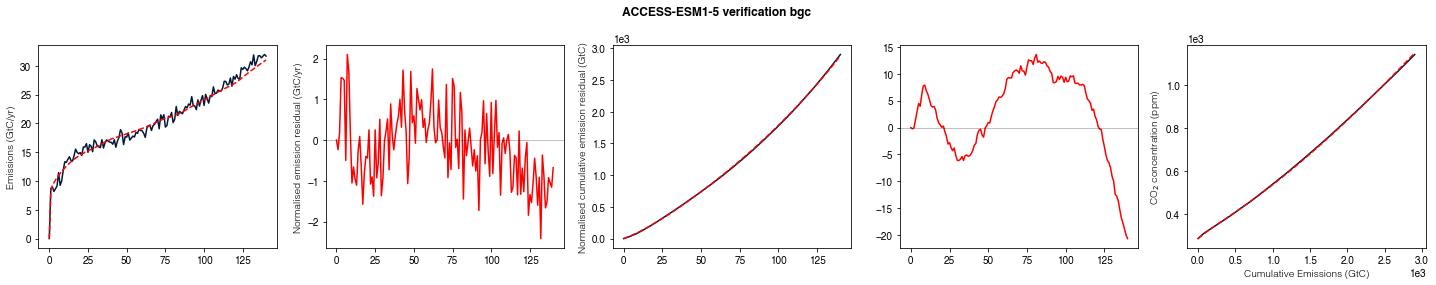

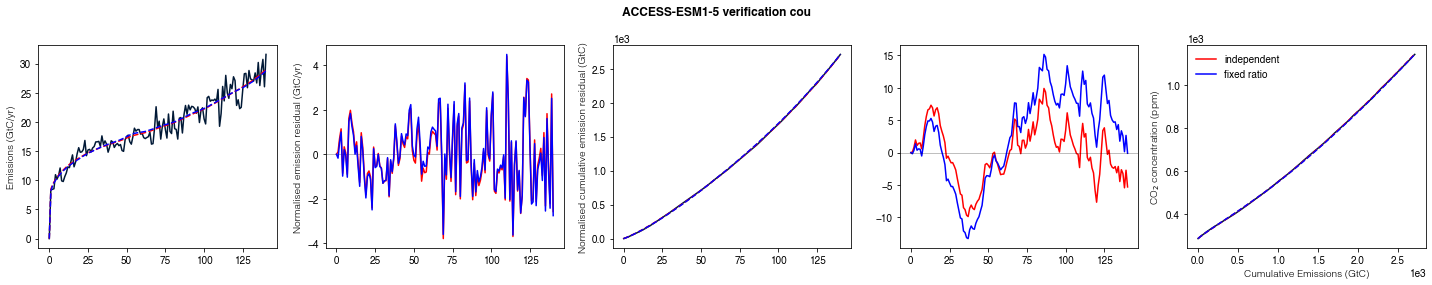

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


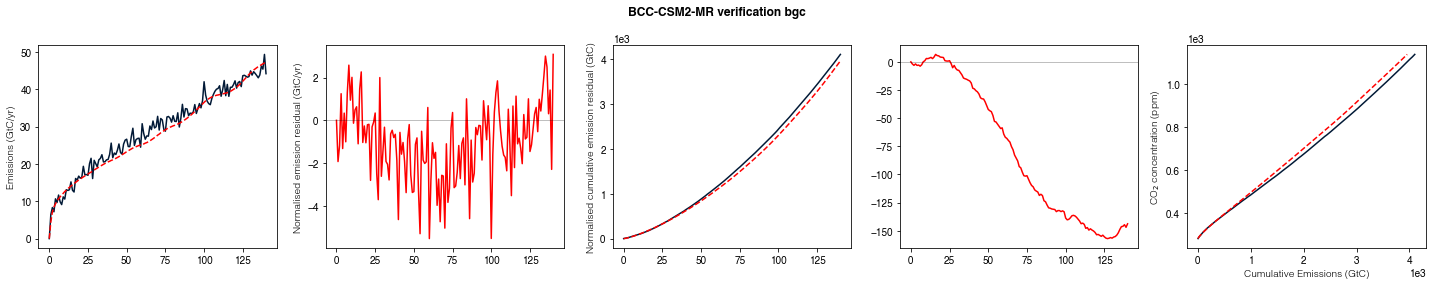

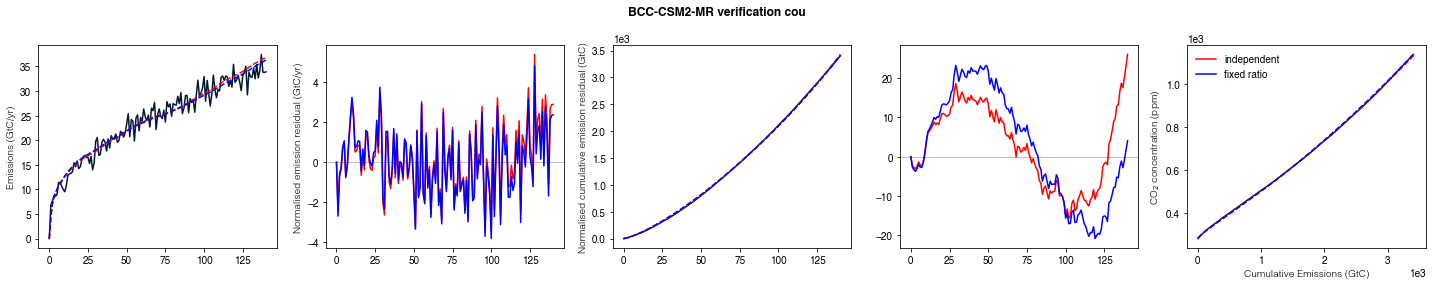

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


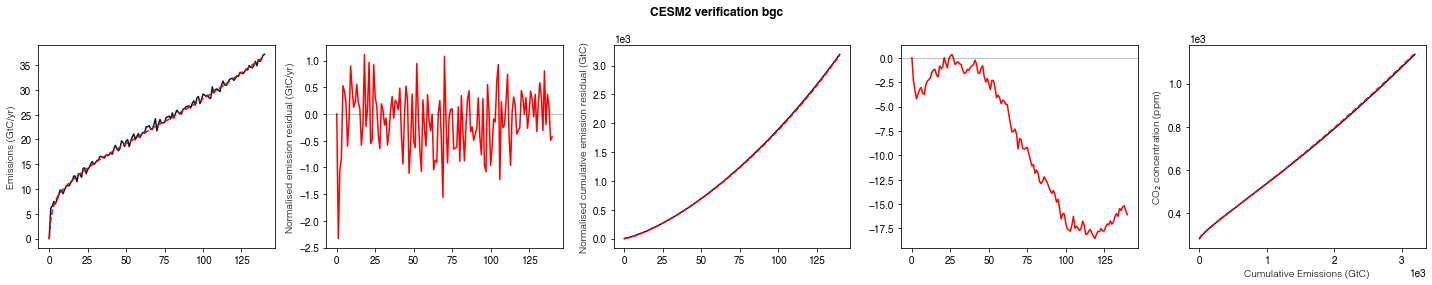

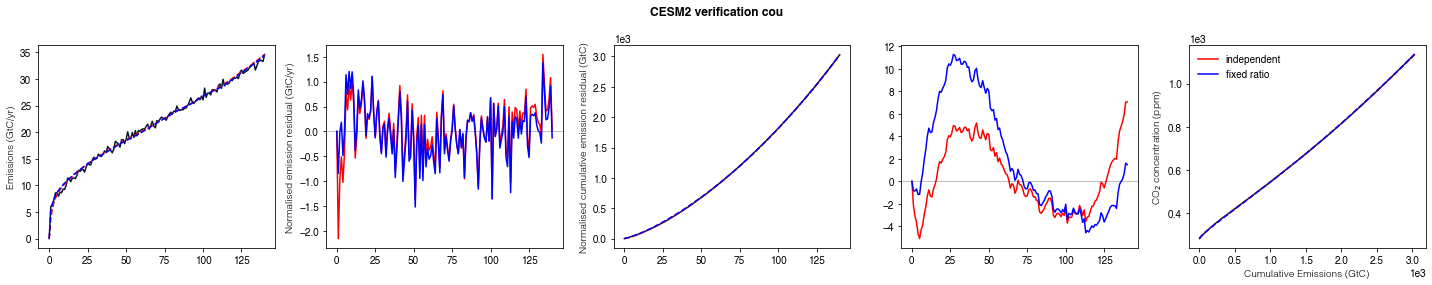

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


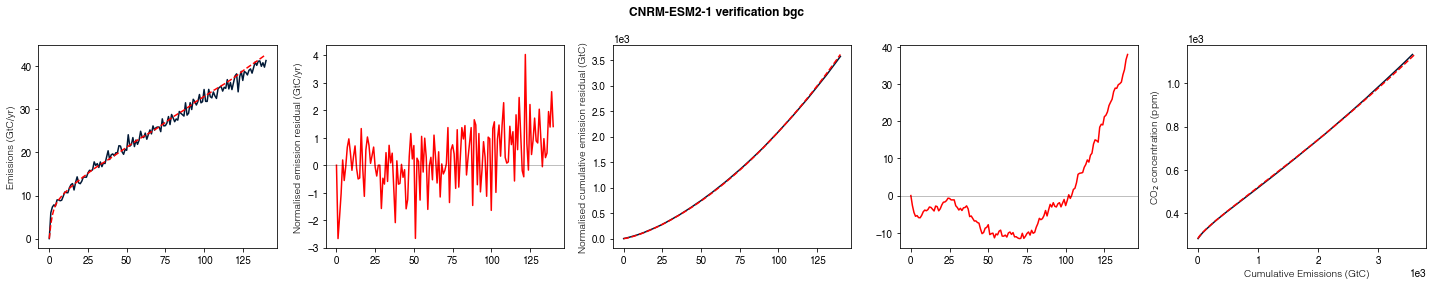

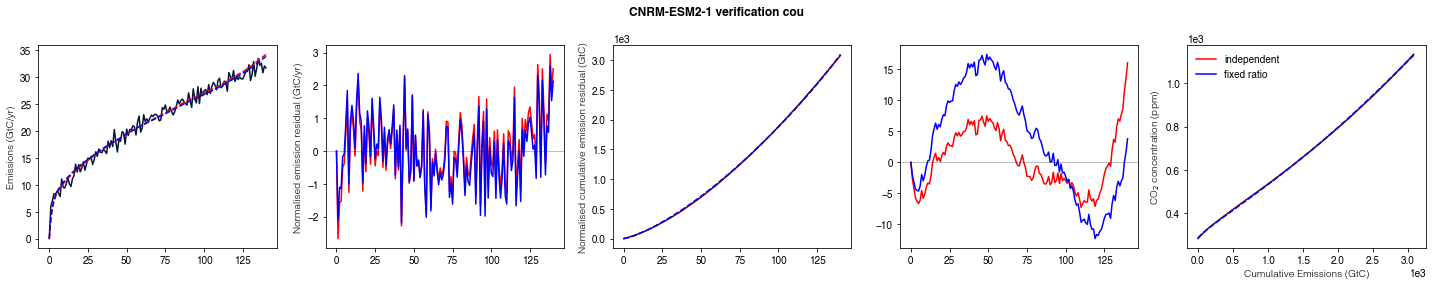

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


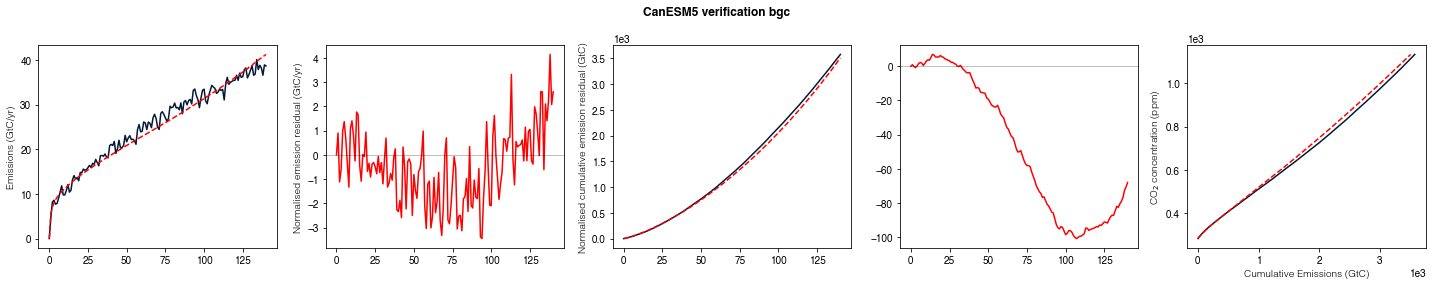

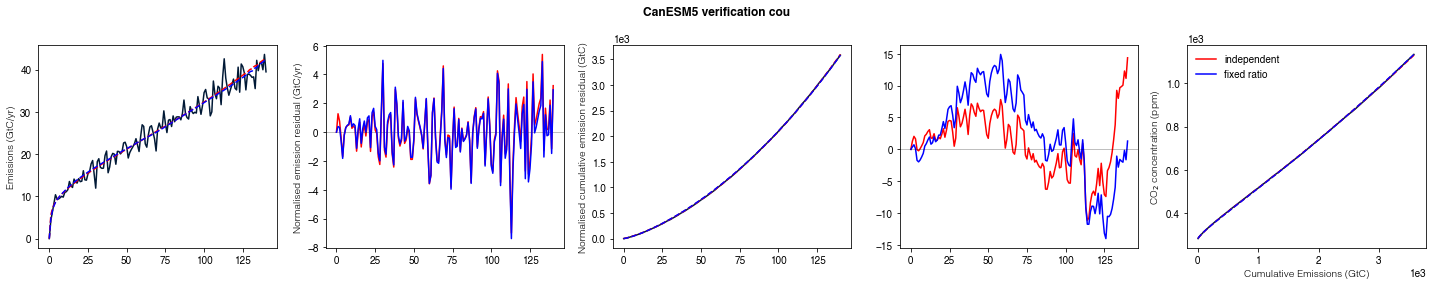

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


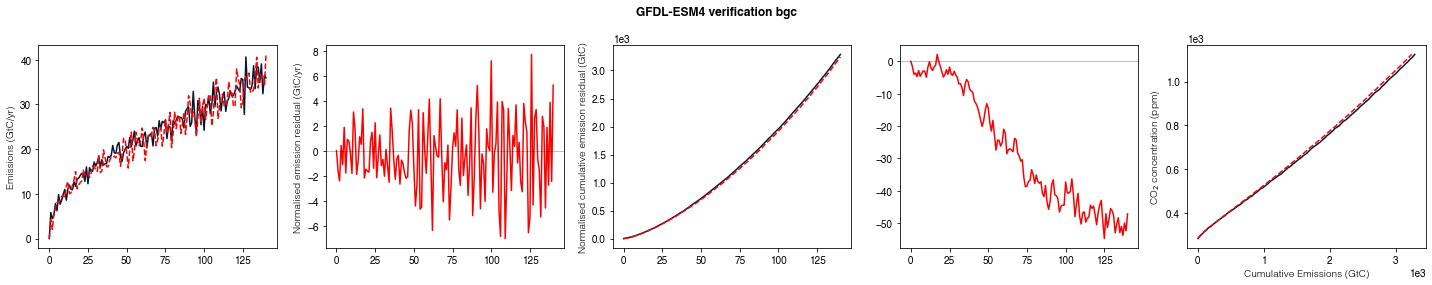

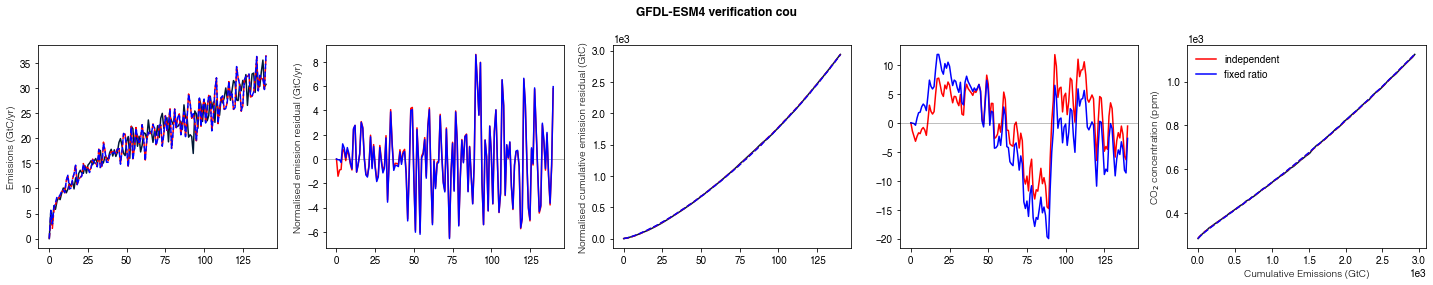

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


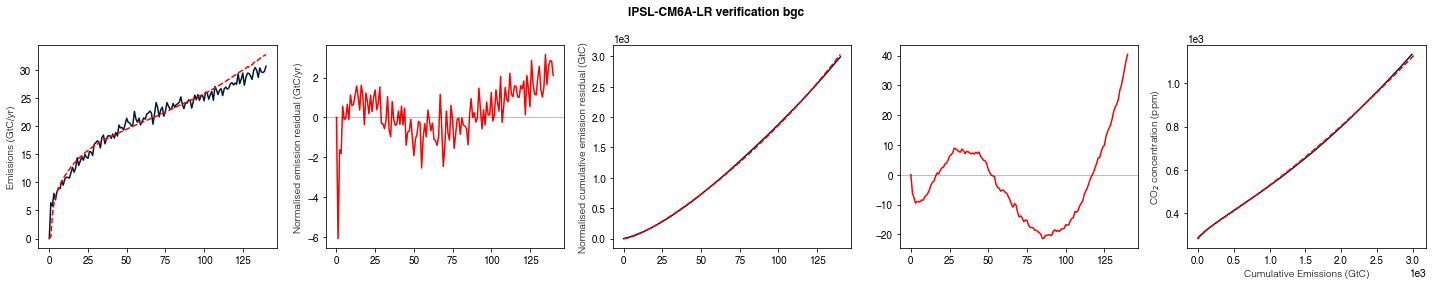

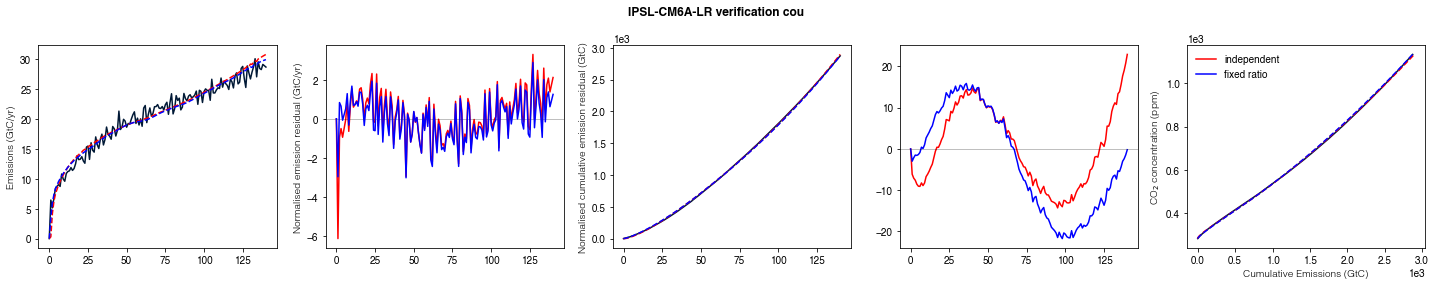

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


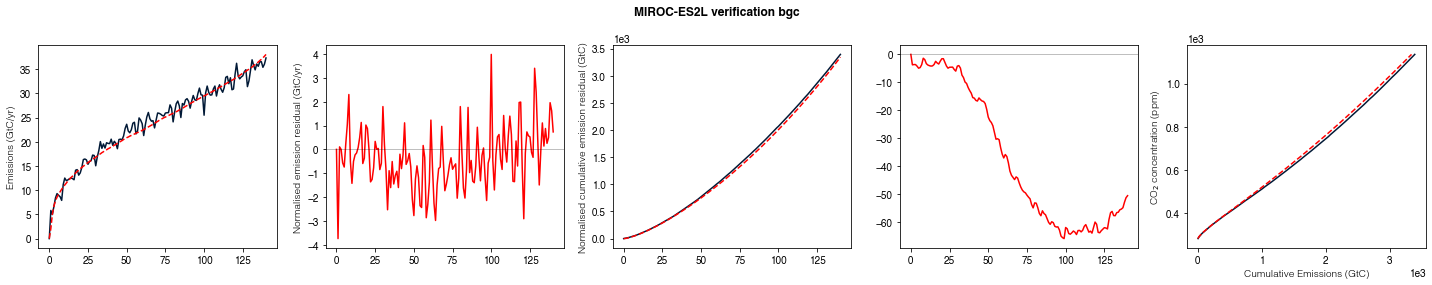

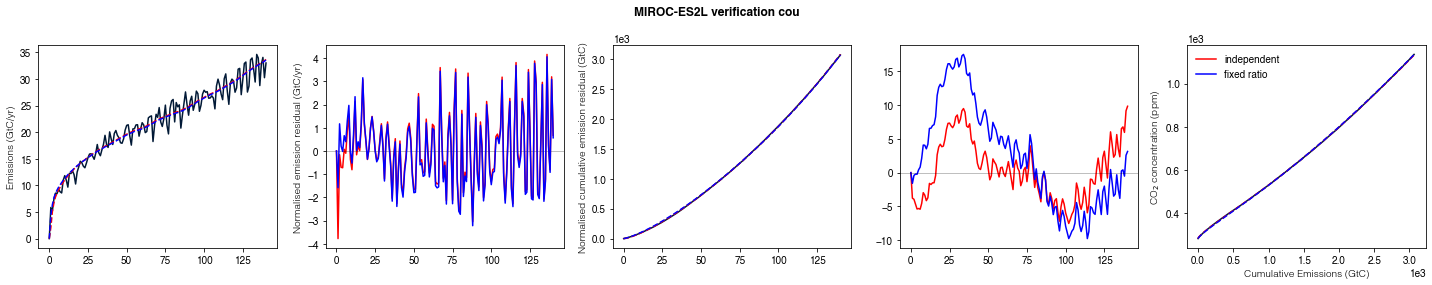

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


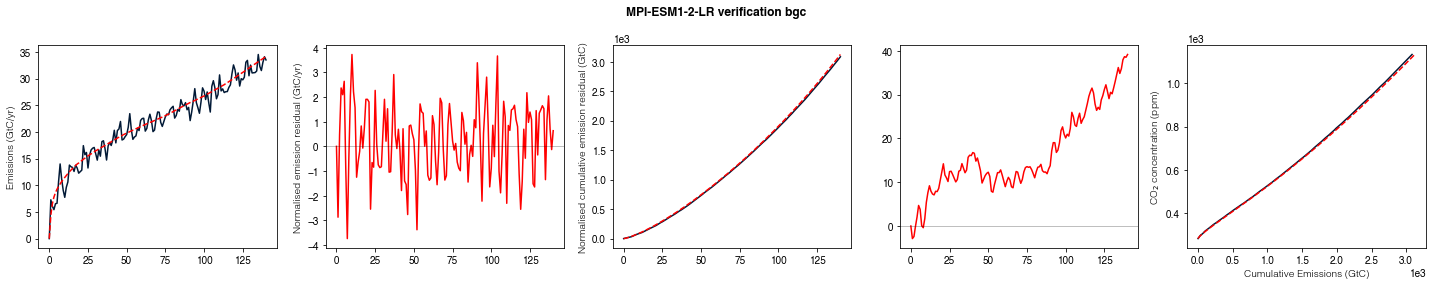

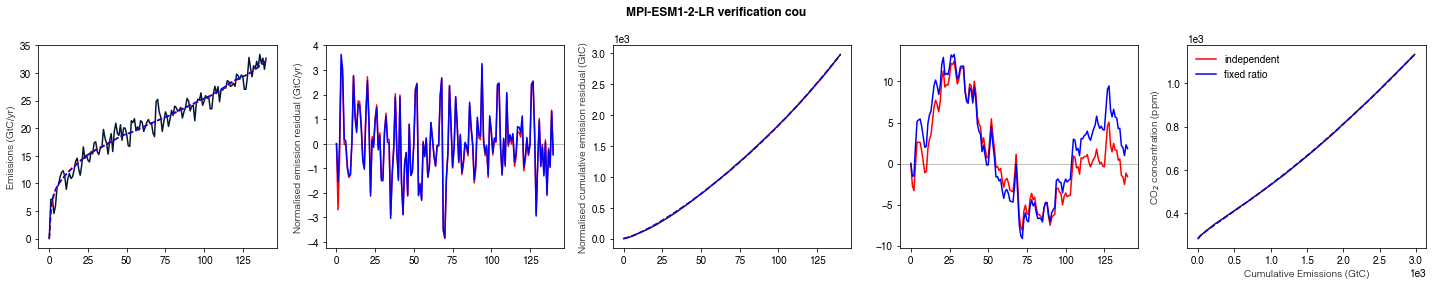

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


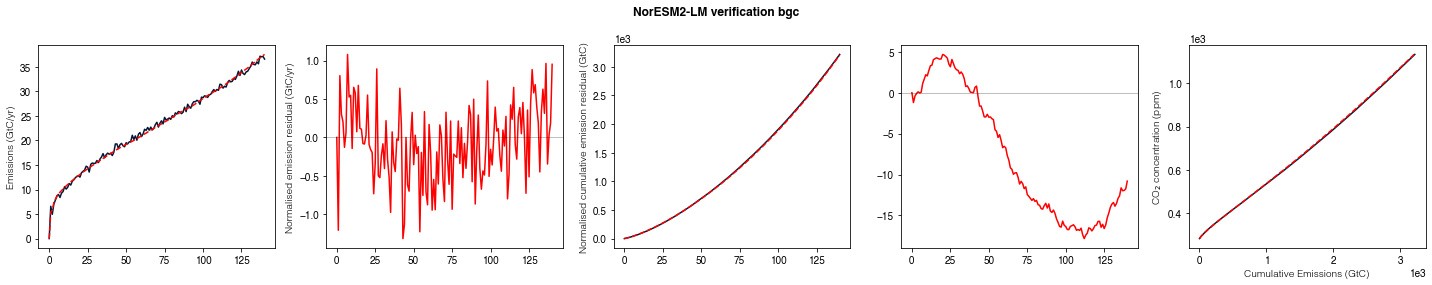

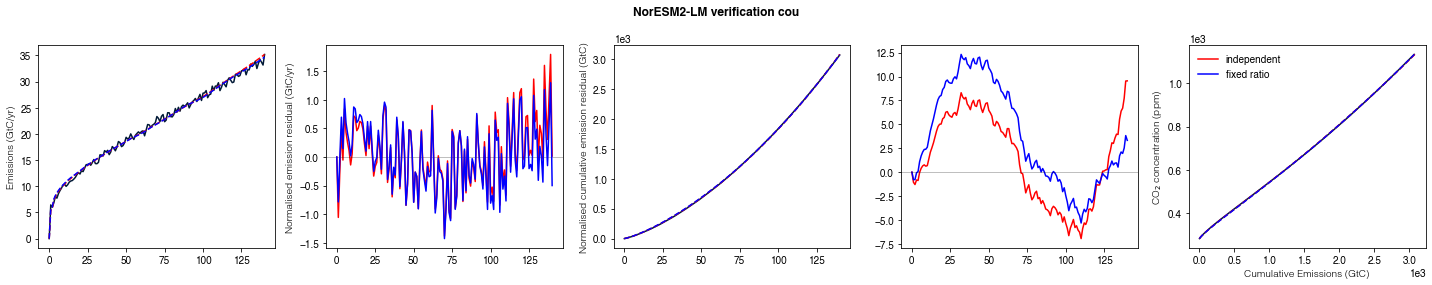

/home/leachl/miniconda3/lib/python3.7/site-packages/pdfo/_dependencies.py:2246: Warning: prepdfo: x0 is revised so that the distance between x0 and the inactive bounds is at least rhobeg; set options['honour_x0']=True if you prefer to keep x0.
  warnings.warn(warn_message, Warning)


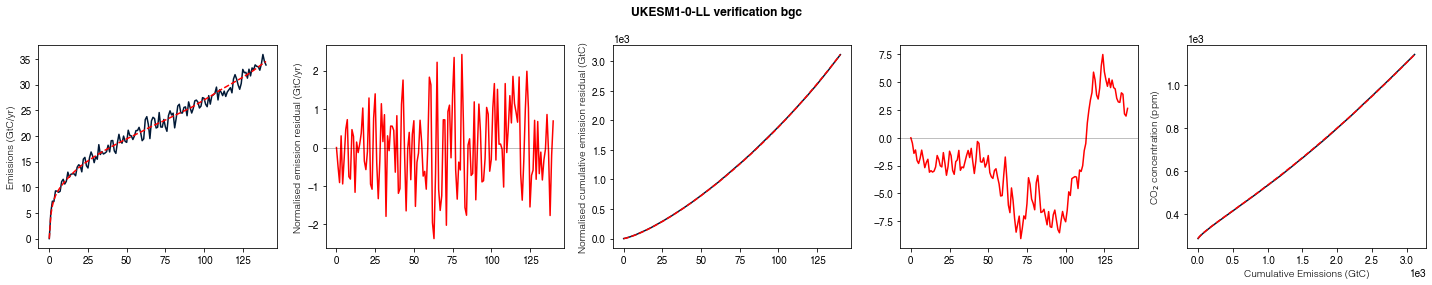

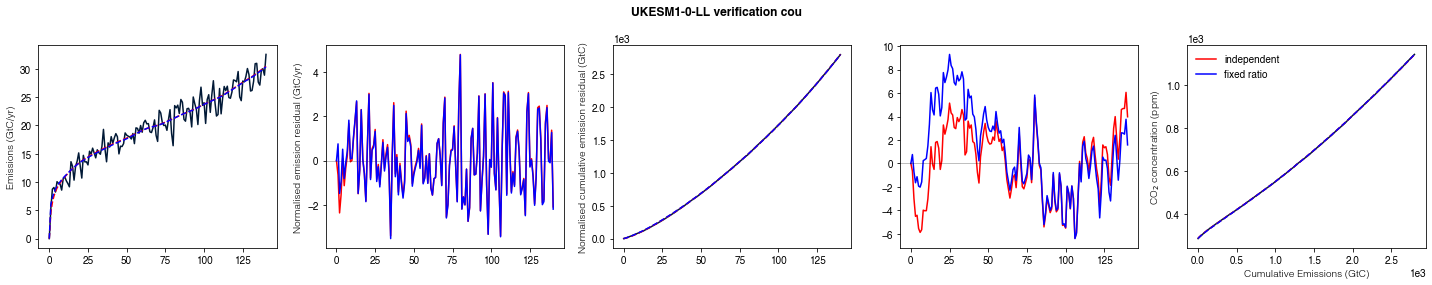

In [754]:
from pdfo import Bounds

# cc_indep_tuning = pd.DataFrame(index=C4MIP_data_1.columns.levels[0],columns=['r0','rC','rT','PI_conc'])

## tune bgc simulations

for model in C4MIP_data_1.columns.levels[0]:

    atms_burden = pd.concat([(C4MIP_data_1.loc[:139,(model,'1pctCO2'+x,'CO2')].dropna()-C4MIP_data_1.loc[:139,(model,'1pctCO2','CO2')].dropna().iloc[0]/1.01)/4.688876e-01 for x in ['','-bgc','-rad']],axis=1)
    cum_emms = pd.concat([C4MIP_data_1.loc[:139,(model,'1pctCO2'+x,'flux')].dropna().cumsum() for x in ['','-bgc','-rad']],axis=1) + atms_burden.values
    concs = C4MIP_data_1.loc[:139,(model,'1pctCO2','CO2')].dropna()
    temps = pd.concat([C4MIP_data_1.loc[:139,(model,'1pctCO2'+x,'tas')].dropna()for x in ['','-bgc','-rad']],axis=1)
    
    b,w = sp.signal.butter(2,0.1)

    C = np.concatenate(([concs.iloc[0]/1.01],concs.values.astype(float)))
    T_bgc = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2-bgc','tas')].values.astype(float))))
    E_bgc = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2-bgc','flux')])))
    T_cou = sp.signal.filtfilt(b,w,np.concatenate(([0],temps.loc[:,(model,'1pctCO2','tas')].values.astype(float))))
    E_cou = np.diff(np.concatenate(([0,0],cum_emms.loc[:,(model,'1pctCO2','flux')])))

    lb = [20,-0.1,-10,270]
    ub = [45,0.1,10,310]
    bounds = Bounds(lb,ub)
    
    bgc_rate_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],0,0]),x[3],C,T_bgc,E_bgc,cost='rate'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun
    bgc_cum_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],0,0]),x[3],C,T_bgc,E_bgc,cost='cumulative'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun
    cou_rate_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_cou,E_cou,cost='rate'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun
    cou_cum_weight = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_cou,E_cou,cost='cumulative'),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15}).fun

    results = pdfo(lambda x: tune_cc(np.array([x[0],x[1],0,0]),x[3],C,T_bgc,E_bgc,cost='rate',rate_weight=bgc_rate_weight,cum_weight=bgc_cum_weight)+tune_cc(np.array([x[0],x[1],x[2],0]),x[3],C,T_cou,E_cou,cost='both',rate_weight=cou_rate_weight,cum_weight=cou_cum_weight),x0=[30,0.02,4,280],bounds=bounds,method='bobyqa',options={'npt':15})
    
    fig,ax = plt.subplots(1,5,figsize=(20,4))
    r_verify = np.array([results.x[0],results.x[1],results.x[2],0])
    verify_tuning(ax,C,T_bgc,E_bgc,r_verify,results.x[3],color='red')
    fig.suptitle(model+' verification bgc',fontweight='bold')
    plt.tight_layout()
    
    fig,ax = plt.subplots(1,5,figsize=(20,4))
    verify_tuning(ax,C,T_cou,E_cou,r_verify,results.x[3],color='red')
    fig.suptitle(model+' verification cou',fontweight='bold')
    
    cc_indep_tuning.loc[model,:] = results.x
    
    ## now we check against the fixed ratio tuning
    
    lb = [20,0,270]
    ub = [45,0.1,300]
    bounds = Bounds(lb,ub)
    
    resultsfixed = pdfo(lambda x: tune_cc(np.array([x[0],x[1],x[1]*4.165/0.019,0]),x[2],C,T_cou,E_cou,cost='rate'),x0=[30,0.019,280],bounds=bounds,method='bobyqa',options={'npt':10})
    
    r_verify = np.array([resultsfixed.x[0],resultsfixed.x[1],resultsfixed.x[1]*4.165/0.019,0])
    verify_tuning(ax,C,T_cou,E_cou,r_verify,resultsfixed.x[2],plot_over=False,color='blue')
    ax[-1].plot([],[],'red',label='independent')
    ax[-1].plot([],[],'blue',label='fixed ratio')
    ax[-1].legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [756]:
cc_indep_tuning.to_csv('../Parameter_Sets/CMIP6_1pctCO2_cc_15082020_indep_rCrT.csv')

In [549]:
## verify the parameters by plotting the uptake difference between the bgc and cou & the actual rad uptake